# **Regression with an Abalone Dataset**


## Data downloading

In [ ]:
# @title Kaggle Competition Data Downloading  { display-mode: "form",run :"auto" }
# @markdown Put the competition name
kaggle_username = 'Kaggle_Username'     # @param ['Kaggle_Username', 'kaggle_username', 'kaggle_2']
kaggle_token = "Kaggle"     # @param ["Kaggle", 'kaggle', 'kaggle_2_pass']

project_name = 'playground-series-s4e4'  # @param {type: "string"}


from google.colab import userdata
from IPython import display
import os
token = {"username":userdata.get(kaggle_username),"key":userdata.get(kaggle_token)}
import os, json
os.environ['KAGGLE_CONFIG_DIR']='.'
with open('kaggle.json', "w") as f:
    json.dump(token, f)
!chmod 600 ./kaggle.json
!kaggle competitions download -c $project_name
project_name += ".zip"
!unzip -o $project_name && rm $project_name
os.environ['MLFLOW_TRACKING_PASSWORD'] = userdata.get('MLFLOW_TRACKING_PASSWORD')
os.environ['MLFLOW_TRACKING_USERNAME'] = userdata.get('MLFLOW_TRACKING_USERNAME')
display.clear_output()
print("Files have been downloaded!")

Files have been downloaded!


In [ ]:
!pip install optuna-dashboard optuna
!pip install mlflow dagshub shap
!pip install ucimlrepo
!pip install catboost
!mkdir -p output/models
!mkdir output/data
!pip install --upgrade gdown
!pip install scikit-learn==1.4
display.clear_output()
import dagshub
import mlflow
import optuna
display.clear_output()

In [ ]:
dagshub.init("Kaggle-Competitions-Lab", "SantanuK", mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=1f91a04a-738c-4c47-8670-588b5eb06094&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=5d91005887d39d61200c9336045d56c49933a7d3b13180579eb8ceec13157c27




Initialized MLflow to track repo "SantanuK/Kaggle-Competitions-Lab"

Repository SantanuK/Kaggle-Competitions-Lab initialized!

In [ ]:
from scipy.stats import pearsonr
x = [1, 3, 5, 8, 9]
y = [7, 12, 15, 24, 29]
pearsonr(x,y)

PearsonRResult(statistic=0.9886849282691559, pvalue=0.001442385473185273)

[link](https://dagshub.com/SantanuK/Kaggle-Competitions-Lab.mlflow/#/experiments/2?searchFilter=&orderByKey=attributes.start_time&orderByAsc=false&startTime=ALL&lifecycleFilter=Active&datasetsFilter=W10%3D&modelVersionFilter=All%20Runs&selectedColumns=attributes.%60Source%60,attributes.%60Models%60,attributes.%60Dataset%60&compareRunCharts=W3sidXVpZCI6IjE3MTE5NDAzNDYwMjhpOXYyY21sMiIsInR5cGUiOiJQQVJBTExFTCIsInJ1bnNDb3VudFRvQ29tcGFyZSI6MTAsInNlbGVjdGVkUGFyYW1zIjpbXSwic2VsZWN0ZWRNZXRyaWNzIjpbXX1d)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import anderson,kstest, shapiro
from IPython.display import Audio,display as dis
from IPython.display import clear_output

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge

In [ ]:
# plotly libraries setup
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = "colab"
pd.set_option('display.max_columns', None)

# import plotly.offline as pyo
# pyo.init_notebook_mode()

In [ ]:
experiment_name = 'Regression with Abalone Dataset'
try:
    mlflow.create_experiment(experiment_name)
    mlflow.set_experiment(experiment_name)
except Exception as e:
    mlflow.set_experiment(experiment_name)
    # print("Experiment has been created or some issue occured!\n","Error: ", e )

### UCIML dataset download

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
abalone = fetch_ucirepo(id=1)

# data (as pandas dataframes)
X = abalone.data.features
y = abalone.data.targets

# metadata
print(abalone.metadata)

# variable information
print(abalone.variables)


{'uci_id': 1, 'name': 'Abalone', 'repository_url': 'https://archive.ics.uci.edu/dataset/1/abalone', 'data_url': 'https://archive.ics.uci.edu/static/public/1/data.csv', 'abstract': 'Predict the age of abalone from physical measurements', 'area': 'Biology', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Tabular'], 'num_instances': 4177, 'num_features': 8, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': [], 'target_col': ['Rings'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C55C7W', 'creators': ['Warwick Nash', 'Tracy Sellers', 'Simon Talbot', 'Andrew Cawthorn', 'Wes Ford'], 'intro_paper': None, 'additional_info': {'summary': 'Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- 

In [ ]:
df_train = pd.read_csv('train.csv',).drop('id', axis=1)
df_test = pd.read_csv('test.csv',).drop('id', axis=1)
sub = pd.read_csv('sample_submission.csv')

In [ ]:
X.head()

Sex  Length  Diameter  Height  Whole_weight  Shucked_weight  Viscera_weight  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Shell_weight  
0         0.150  
1         0.070  
2         0.210  
3         0.155  
4         0.055

In [ ]:
# X.describe()
# df_train.descr+ibe()
# df_test.describe()

In [ ]:
df_train['Rings'].nunique(), y['Rings'].nunique()

(28, 28)

In [ ]:
df_train['Sex'].unique(), X['Sex'].unique()

(array(['F', 'I', 'M'], dtype=object), array(['M', 'F', 'I'], dtype=object))

In [ ]:
np.sort(y['Rings'].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29])

In [ ]:
np.sort(df_train['Rings'].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29])

In [ ]:
df_extra = X.copy()
df_extra['Rings'] = y.copy()
df_extra.columns = df_train.columns
df_extra.head()

Sex  Length  Diameter  Height  Whole weight  Whole weight.1  Whole weight.2  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Shell weight  Rings  
0         0.150     15  
1         0.070      7  
2         0.210      9  
3         0.155     10  
4         0.055      7

In [ ]:
from sklearn.metrics import (root_mean_squared_log_error as RMLE,
                             r2_score)
# 'neg_root_mean_squared_log_error'
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import VALID_METRICS

from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import (AdaBoostRegressor, ExtraTreesRegressor,
                              BaggingRegressor, RandomForestRegressor,
                              GradientBoostingRegressor,
                              HistGradientBoostingRegressor,
                              StackingRegressor
                              )
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from catboost import CatBoostRegressor

In [ ]:
df_train['Sex'] = df_train['Sex'].replace({'F':0,"M":1,'I':2})
df_test['Sex'] = df_test['Sex'].replace({'F':0,"M":1,'I':2})
df_extra['Sex'] = df_extra['Sex'].replace({'F':0,"M":1,'I':2})

### Required functions

In [ ]:
target_feature = 'Rings'

def preprocessing(dataframe, target_feature=target_feature):
    df = dataframe.copy()
    df['Viscera ratio'] = df['Viscera weight']/df['Whole weight']
    df['Shell ratio'] = df['Shell weight']/df['Whole weight']
    df['Shell to body ratio'] = df['Shell weight']/(df['Whole weight']+df['Shell weight'])
    df['Meat yield'] = df['Shucked weight']/(df['Whole weight']+df['Shell weight'])
    df['Length to diameter ratio'] = df['Length']/df['Diameter']
    df['Weight to Viscera ratio'] = df['Whole weight']/df['Viscera weight']
    df['Weight to Shell ratio'] = df['Whole weight']/df['Shell weight']
    df['Weight to Shucked ratio'] = df['Whole weight']/df['Shucked weight']

    df['Height'] = df['Height'].replace({0: .004}) # replaced withh min value
    df['Surface area'] = df['Length']*df['Height'] + df['Length']*df['Diameter']+df['Diameter']*df['Height']
    df['Volume'] = df['Height']*df['Length']*df['Diameter']
    df['Density'] = df['Whole weight']/df['Volume']
    df['Pseudo BMI 1'] = df['Whole weight']/(df['Height']**2)
    df['Pseudo BMI 2'] = df['Whole weight']/(df['Length']**2)
    df['Pseudo BMI 3'] = df['Whole weight']/(df['Diameter']**2)

    df['Body condition index'] = (df['Length']*df['Whole weight']*df['Shucked weight'])

    try:
        df = df.drop(target_feature, axis=1)
        df[target_feature]= dataframe[target_feature]
    finally:
        return df


def select_model(dataframe, test_size=.3, target_feature=target_feature):
    !mkdir -p output/data
    algos = [
            #  SVC(), NuSVC(),
            #  LinearRegression(),
            DecisionTreeRegressor(), ExtraTreeRegressor(),
            AdaBoostRegressor(), BaggingRegressor(),
            ExtraTreesRegressor(), RandomForestRegressor(),
            GradientBoostingRegressor(),
            HistGradientBoostingRegressor(),
            LGBMRegressor(verbose=-1), XGBRegressor(), XGBRFRegressor(),
            CatBoostRegressor(verbose=0)
            ]
    names = list(map(lambda x: x.__class__.__name__, algos))

    history = { 'algo_name': names,
                'train_score' : [],
                'test_score' : [],
                # 'Min_1': [],
                # 'Min_2': [],
                'train_metrics': [],
                'test_metrics': [],
                }
    X_train, X_test, y_train, y_test = train_test_split(dataframe.drop(target_feature, axis=1), dataframe[target_feature], test_size=test_size)
    for model in algos:
        print(f"{model.__class__.__name__} has started!")
        model.fit(X_train, y_train)
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        history['train_score'].append(r2_score(y_train, pred_train))
        history['test_score'].append(r2_score(y_test, pred_test))
        try:
            # history['Min_1'].append(np.min(pred_train))
            # history['Min_2'].append(np.min(pred_test))

            history['train_metrics'].append(RMLE(y_train, pred_train))
            history['test_metrics'].append(RMLE(y_test, pred_test))
        except Exception as e:
            # history['Min_1'].append(np.nan)
            # history['Min_2'].append(np.nan)
            history['train_metrics'].append(np.nan)
            history['test_metrics'].append(np.nan)
    return pd.DataFrame(history)


In [ ]:
features = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']
df_train.columns = features
df_test.columns = features[:-1]
df_extra.columns = features

df_merged= pd.concat([df_test, df_extra.drop(target_feature,axis=1)])
indices = df_merged[df_merged.duplicated()].index
df_common = df_extra.iloc[indices,:].copy()

train = preprocessing(df_train)
test = preprocessing(df_test)
extra = preprocessing(df_extra)
common = preprocessing(df_common)

X_train, X_test, y_train, y_test = train_test_split(train.drop(target_feature, axis=1),
                                                    train[target_feature], test_size=.3, random_state=657)
def calc_score(model):
    return (RMLE(y_train, model.predict(X_train)),
    RMLE(y_test, model.predict(X_test)),
    RMLE(extra[target_feature], model.predict(extra.drop(target_feature,axis=1))))

def append_study(study):
    res_ = {
        'trial_id'      : [],
        'test_score'    : [],
        'margin'        : [],
        'params'        : [],
    }
    for trial in study.best_trials:
        res_['trial_id'].append(trial.number)
        res_['params'].append(trial.params)
        res_['test_score'].append(trial.values[0])
        res_['margin'].append(trial.values[1])

    result_df = pd.DataFrame(res_)
    select_cols = ['trial_id', 'train_score', 'test_score', 'margin', 'params']
    result_df['train_score'] = result_df['test_score'] - result_df['margin']
    result_df = result_df[select_cols]
    return result_df

## Observations

In [ ]:
df_train.head()

Sex  Length  Diameter  Height  Whole weight  Whole weight.1  \
0    0   0.550     0.430   0.150        0.7715          0.3285   
1    0   0.630     0.490   0.145        1.1300          0.4580   
2    2   0.160     0.110   0.025        0.0210          0.0055   
3    1   0.595     0.475   0.150        0.9145          0.3755   
4    2   0.555     0.425   0.130        0.7820          0.3695   

   Whole weight.2  Shell weight  Rings  
0          0.1465        0.2400     11  
1          0.2765        0.3200     11  
2          0.0030        0.0050      6  
3          0.2055        0.2500     10  
4          0.1600        0.1975      9

In [ ]:
df_test.head()

Sex  Length  Diameter  Height  Whole weight  Whole weight.1  \
0    1   0.645     0.475   0.155        1.2380          0.6185   
1    1   0.580     0.460   0.160        0.9830          0.4785   
2    1   0.560     0.420   0.140        0.8395          0.3525   
3    1   0.570     0.490   0.145        0.8740          0.3525   
4    2   0.415     0.325   0.110        0.3580          0.1575   

   Whole weight.2  Shell weight  
0          0.3125        0.3005  
1          0.2195        0.2750  
2          0.1845        0.2405  
3          0.1865        0.2350  
4          0.0670        0.1050

In [ ]:
df_extra.head()

Sex  Length  Diameter  Height  Whole weight  Whole weight.1  \
0    1   0.455     0.365   0.095        0.5140          0.2245   
1    1   0.350     0.265   0.090        0.2255          0.0995   
2    0   0.530     0.420   0.135        0.6770          0.2565   
3    1   0.440     0.365   0.125        0.5160          0.2155   
4    2   0.330     0.255   0.080        0.2050          0.0895   

   Whole weight.2  Shell weight  Rings  
0          0.1010         0.150     15  
1          0.0485         0.070      7  
2          0.1415         0.210      9  
3          0.1140         0.155     10  
4          0.0395         0.055      7

In [ ]:
len(df_train), len(df_extra), len(df_test)

(90615, 4177, 60411)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90615 entries, 0 to 90614
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             90615 non-null  int64  
 1   Length          90615 non-null  float64
 2   Diameter        90615 non-null  float64
 3   Height          90615 non-null  float64
 4   Whole weight    90615 non-null  float64
 5   Whole weight.1  90615 non-null  float64
 6   Whole weight.2  90615 non-null  float64
 7   Shell weight    90615 non-null  float64
 8   Rings           90615 non-null  int64  
dtypes: float64(7), int64(2)
memory usage: 6.2 MB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60411 entries, 0 to 60410
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             60411 non-null  int64  
 1   Length          60411 non-null  float64
 2   Diameter        60411 non-null  float64
 3   Height          60411 non-null  float64
 4   Whole weight    60411 non-null  float64
 5   Whole weight.1  60411 non-null  float64
 6   Whole weight.2  60411 non-null  float64
 7   Shell weight    60411 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 3.7 MB


In [ ]:
df_extra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   int64  
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Whole weight.1  4177 non-null   float64
 6   Whole weight.2  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(2)
memory usage: 293.8 KB


In [ ]:
df_train.describe(include='all')

Sex        Length      Diameter        Height  Whole weight  \
count  90615.000000  90615.000000  90615.000000  90615.000000  90615.000000   
mean       1.072814      0.517098      0.401679      0.135464      0.789035   
std        0.807651      0.118217      0.098026      0.038008      0.457671   
min        0.000000      0.075000      0.055000      0.000000      0.002000   
25%        0.000000      0.445000      0.345000      0.110000      0.419000   
50%        1.000000      0.545000      0.425000      0.140000      0.799500   
75%        2.000000      0.600000      0.470000      0.160000      1.067500   
max        2.000000      0.815000      0.650000      1.130000      2.825500   

       Whole weight.1  Whole weight.2  Shell weight         Rings  
count    90615.000000    90615.000000  90615.000000  90615.000000  
mean         0.340778        0.169422      0.225898      9.696794  
std          0.204428        0.100909      0.130203      3.176221  
min          0.001000        0.000500      0.001500      1.000000  
25%          0.177500        0.086500      0.120000      8.000000  
50%          0.330000        0.166000      0.225000      9.000000  
75%          0.463000        0.232500      0.305000     11.000000  
max          1.488000        0.760000      1.005000     29.000000

In [ ]:
df_test.describe(include='all')

Sex        Length      Diameter        Height  Whole weight  \
count  60411.000000  60411.000000  60411.000000  60411.000000  60411.000000   
mean       1.080350      0.517428      0.401961      0.135751      0.790062   
std        0.805933      0.117609      0.097470      0.038175      0.457591   
min        0.000000      0.075000      0.055000      0.000000      0.002000   
25%        0.000000      0.450000      0.345000      0.110000      0.419500   
50%        1.000000      0.545000      0.425000      0.140000      0.801500   
75%        2.000000      0.600000      0.470000      0.160000      1.070000   
max        2.000000      0.800000      0.650000      1.095000      2.825500   

       Whole weight.1  Whole weight.2  Shell weight  
count    60411.000000    60411.000000  60411.000000  
mean         0.341227        0.169419      0.226125  
std          0.204221        0.100720      0.129826  
min          0.001000        0.000500      0.001500  
25%          0.178500        0.086500      0.120000  
50%          0.329000        0.166000      0.225000  
75%          0.464500        0.232500      0.305000  
max          1.488000        0.641500      1.004000

In [ ]:
df_extra.describe(include='all')

Sex       Length     Diameter       Height  Whole weight  \
count  4177.000000  4177.000000  4177.000000  4177.000000   4177.000000   
mean      1.008379     0.523992     0.407881     0.139516      0.828742   
std       0.796410     0.120093     0.099240     0.041827      0.490389   
min       0.000000     0.075000     0.055000     0.000000      0.002000   
25%       0.000000     0.450000     0.350000     0.115000      0.441500   
50%       1.000000     0.545000     0.425000     0.140000      0.799500   
75%       2.000000     0.615000     0.480000     0.165000      1.153000   
max       2.000000     0.815000     0.650000     1.130000      2.825500   

       Whole weight.1  Whole weight.2  Shell weight        Rings  
count     4177.000000     4177.000000   4177.000000  4177.000000  
mean         0.359367        0.180594      0.238831     9.933684  
std          0.221963        0.109614      0.139203     3.224169  
min          0.001000        0.000500      0.001500     1.000000  
25%          0.186000        0.093500      0.130000     8.000000  
50%          0.336000        0.171000      0.234000     9.000000  
75%          0.502000        0.253000      0.329000    11.000000  
max          1.488000        0.760000      1.005000    29.000000

In [ ]:
# df_train['Height'].value_counts()

In [ ]:
np.sort(df_train['Height'].unique())

array([0.    , 0.004 , 0.005 , 0.009 , 0.01  , 0.015 , 0.019 , 0.02  ,
       0.025 , 0.03  , 0.033 , 0.035 , 0.036 , 0.04  , 0.044 , 0.045 ,
       0.046 , 0.05  , 0.055 , 0.057 , 0.06  , 0.0615, 0.065 , 0.07  ,
       0.0735, 0.075 , 0.08  , 0.082 , 0.0825, 0.083 , 0.085 , 0.088 ,
       0.09  , 0.0915, 0.092 , 0.0925, 0.095 , 0.1   , 0.103 , 0.105 ,
       0.106 , 0.11  , 0.113 , 0.115 , 0.116 , 0.117 , 0.119 , 0.12  ,
       0.121 , 0.123 , 0.125 , 0.13  , 0.135 , 0.14  , 0.145 , 0.147 ,
       0.15  , 0.155 , 0.156 , 0.16  , 0.165 , 0.167 , 0.169 , 0.17  ,
       0.175 , 0.18  , 0.184 , 0.185 , 0.19  , 0.195 , 0.2   , 0.205 ,
       0.21  , 0.215 , 0.22  , 0.225 , 0.23  , 0.235 , 0.24  , 0.245 ,
       0.25  , 0.255 , 0.26  , 0.265 , 0.3   , 0.35  , 0.5   , 0.515 ,
       1.    , 1.13  ])

In [ ]:
np.sort(df_test['Height'].unique())

array([0.    , 0.005 , 0.01  , 0.0105, 0.015 , 0.02  , 0.025 , 0.03  ,
       0.035 , 0.04  , 0.045 , 0.046 , 0.048 , 0.05  , 0.052 , 0.055 ,
       0.057 , 0.06  , 0.065 , 0.07  , 0.075 , 0.08  , 0.082 , 0.0825,
       0.085 , 0.087 , 0.088 , 0.09  , 0.093 , 0.095 , 0.0985, 0.1   ,
       0.103 , 0.1035, 0.104 , 0.105 , 0.109 , 0.11  , 0.1105, 0.111 ,
       0.113 , 0.115 , 0.119 , 0.12  , 0.122 , 0.123 , 0.125 , 0.13  ,
       0.131 , 0.135 , 0.14  , 0.145 , 0.15  , 0.155 , 0.16  , 0.165 ,
       0.17  , 0.175 , 0.18  , 0.185 , 0.19  , 0.195 , 0.2   , 0.205 ,
       0.21  , 0.215 , 0.22  , 0.225 , 0.23  , 0.235 , 0.24  , 0.245 ,
       0.25  , 0.255 , 0.27  , 0.29  , 0.35  , 0.375 , 0.495 , 0.515 ,
       0.6   , 0.65  , 1.005 , 1.065 , 1.095 ])

In [ ]:
np.sort(df_extra['Height'].unique())

array([0.   , 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045,
       0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 ,
       0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 , 0.135,
       0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175, 0.18 ,
       0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 , 0.225,
       0.23 , 0.235, 0.24 , 0.25 , 0.515, 1.13 ])

### Height can not be zero

In [ ]:
df_train[df_train['Height']==0]

Sex  Length  Diameter  Height  Whole weight  Whole weight.1  \
7025     2   0.315     0.230     0.0        0.1340          0.0545   
14208    2   0.430     0.340     0.0        0.3440          0.1880   
32078    1   0.470     0.355     0.0        0.5785          0.2965   
52324    2   0.315     0.230     0.0        0.1340          0.0530   
70295    2   0.430     0.340     0.0        0.4060          0.2035   
90295    1   0.430     0.325     0.0        0.3335          0.1350   

       Whole weight.2  Shell weight  Rings  
7025           0.0245        0.3505      8  
14208          0.0705        0.1050      8  
32078          0.1550        0.1360      7  
52324          0.0375        0.3505      7  
70295          0.0960        0.1230      7  
90295          0.0585        0.1050     10

In [ ]:
df_test[df_test['Height']==0]

Sex  Length  Diameter  Height  Whole weight  Whole weight.1  \
34067    1    0.56     0.445     0.0        0.8725           0.305   
42004    2    0.27     0.195     0.0        0.0840           0.025   

       Whole weight.2  Shell weight  
34067           0.190         0.305  
42004           0.049         0.031

In [ ]:
df_extra[df_extra['Height']==0]

Sex  Length  Diameter  Height  Whole weight  Whole weight.1  \
1257    2   0.430      0.34     0.0         0.428          0.2065   
3996    2   0.315      0.23     0.0         0.134          0.0575   

      Whole weight.2  Shell weight  Rings  
1257          0.0860        0.1150      8  
3996          0.0285        0.3505      6

In [ ]:
filter = df_train['Sex']==2
df_train[filter].describe()

Sex        Length      Diameter        Height  Whole weight  \
count  33093.0  33093.000000  33093.000000  33093.000000  33093.000000   
mean       2.0      0.414792      0.315766      0.103129      0.396115   
std        0.0      0.104592      0.085249      0.029335      0.261157   
min        2.0      0.075000      0.055000      0.000000      0.002000   
25%        2.0      0.345000      0.260000      0.085000      0.187000   
50%        2.0      0.425000      0.325000      0.100000      0.356500   
75%        2.0      0.495000      0.380000      0.125000      0.573000   
max        2.0      0.770000      0.600000      0.230000      2.779500   

       Whole weight.1  Whole weight.2  Shell weight         Rings  
count    33093.000000    33093.000000  33093.000000  33093.000000  
mean         0.173873        0.083415      0.114645      7.533557  
std          0.117814        0.056068      0.075507      2.131495  
min          0.001000        0.000500      0.001500      1.000000  
25%          0.078500        0.039000      0.056000      6.000000  
50%          0.157500        0.073500      0.100000      7.000000  
75%          0.250000        0.118500      0.161500      8.000000  
max          1.145500        0.548000      0.885000     29.000000

In [ ]:
filter = df_extra['Sex']==2
df_extra[filter].describe()

Sex       Length     Diameter       Height  Whole weight  \
count  1342.0  1342.000000  1342.000000  1342.000000   1342.000000   
mean      2.0     0.427746     0.326494     0.107996      0.431363   
std       0.0     0.108858     0.088109     0.031995      0.286275   
min       2.0     0.075000     0.055000     0.000000      0.002000   
25%       2.0     0.360000     0.270000     0.085000      0.205500   
50%       2.0     0.435000     0.335000     0.110000      0.384000   
75%       2.0     0.510000     0.390000     0.130000      0.599375   
max       2.0     0.725000     0.550000     0.220000      2.049500   

       Whole weight.1  Whole weight.2  Shell weight        Rings  
count     1342.000000     1342.000000   1342.000000  1342.000000  
mean         0.191035        0.092010      0.128182     7.890462  
std          0.128405        0.062536      0.084927     2.511554  
min          0.001000        0.000500      0.001500     1.000000  
25%          0.090000        0.042500      0.064125     6.000000  
50%          0.169750        0.080500      0.113000     8.000000  
75%          0.270375        0.130000      0.178500     9.000000  
max          0.773500        0.440500      0.655000    21.000000

In [ ]:
df_train.columns

Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1',
       'Whole weight.2', 'Shell weight', 'Rings'],
      dtype='object')

In [ ]:
num_features = ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight',]
cat_feature = ['Sex']
target_feature = 'Rings'

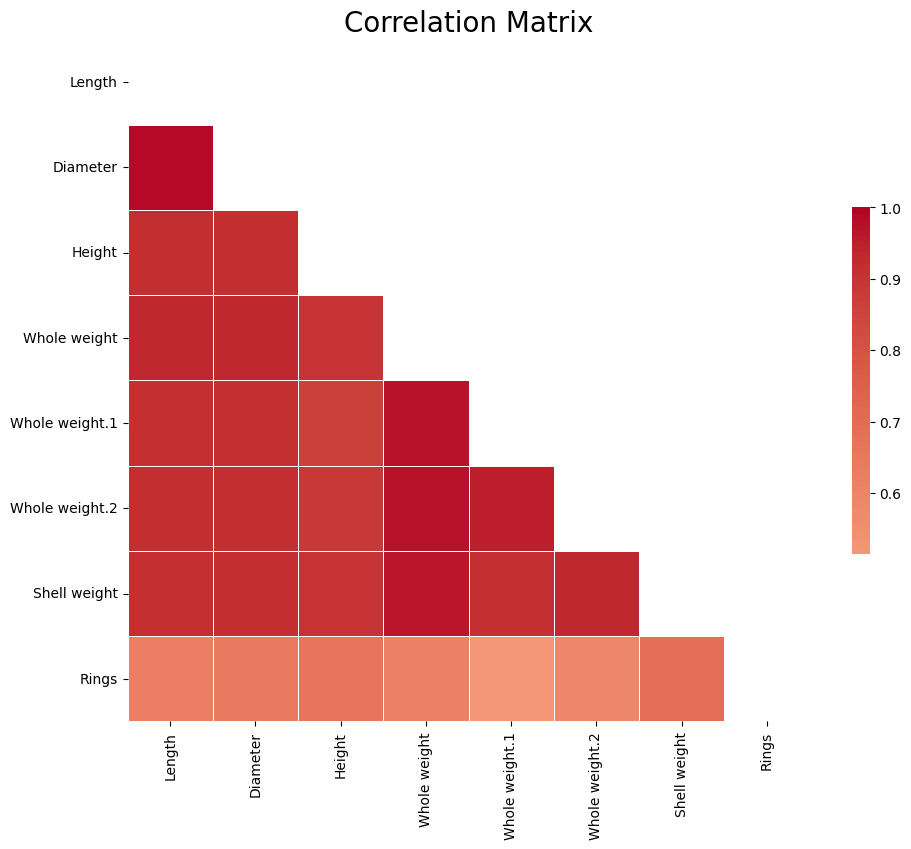

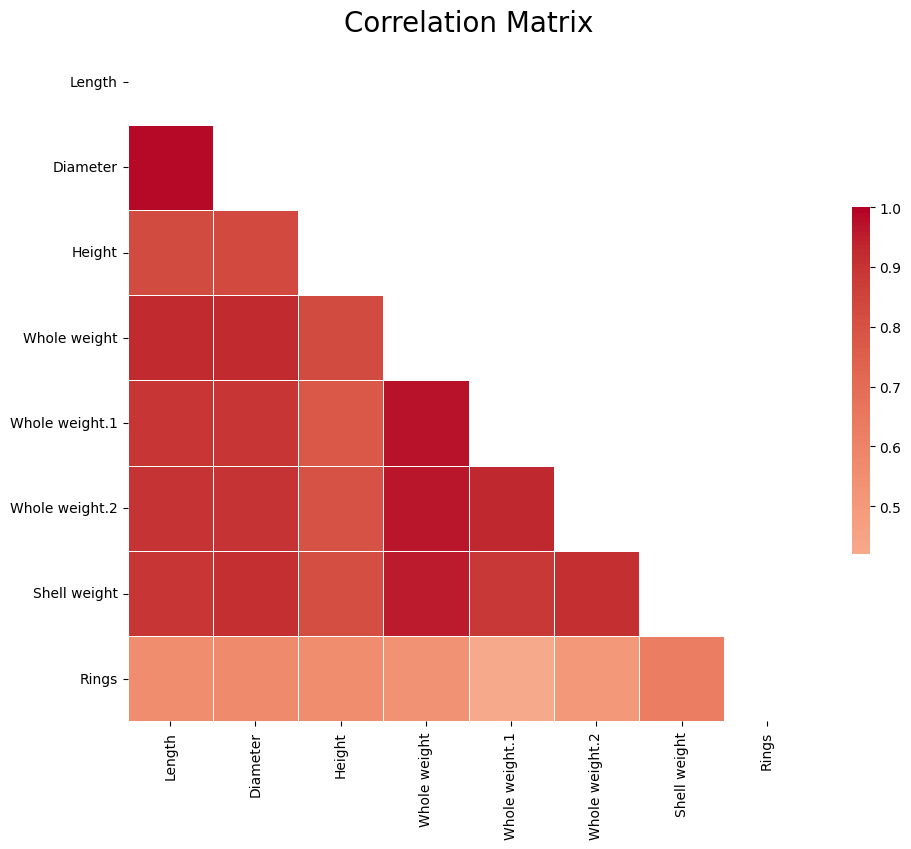

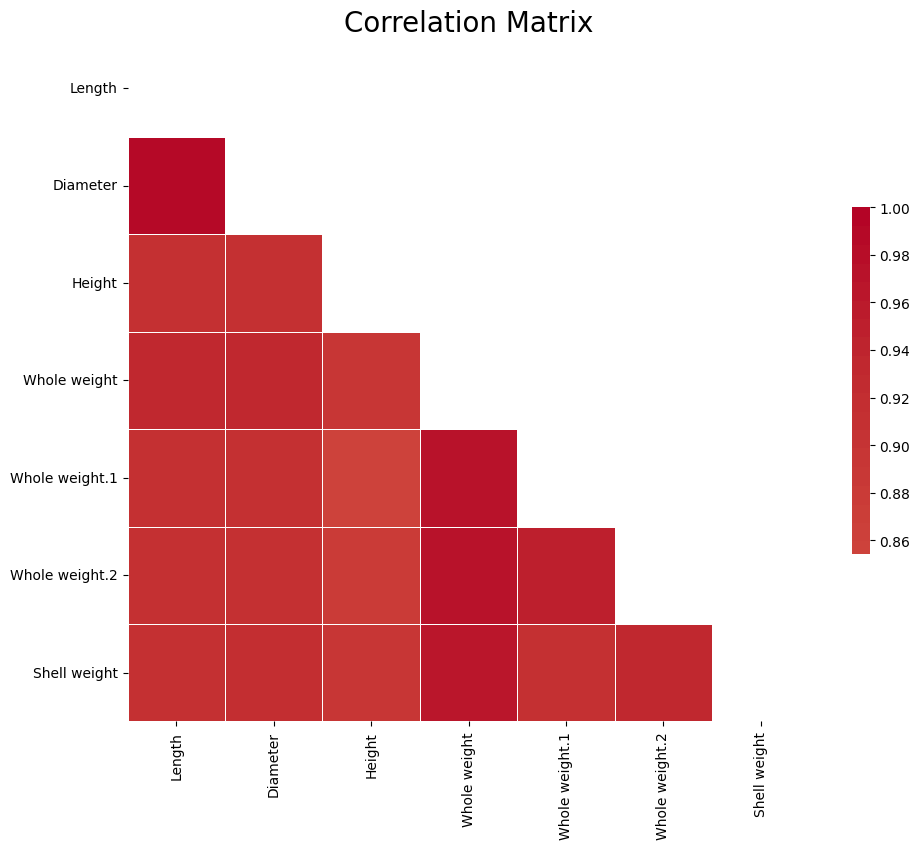

In [ ]:
for i, df in enumerate([df_train, df_extra, df_test]):
    try:
        corr = df[num_features+[target_feature,]].corr()
    except KeyError as e:
        corr = df[num_features].corr()
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.title('Correlation Matrix', fontsize=20)
    !mkdir -p output/images
    plt.savefig(f"output/images/Correlation matrix_{i+1}.png")
    plt.show()

### Summary:

1. This dataset can be treated as classification too. (only problem is to predict 28)
1. There is some zero length, diameter.

In [ ]:
# import sklearn
# print(sklearn.__version__)
# from sklearn.metrics import root_mean_squared_log_error


1.4.0


In [ ]:
# y_true = [3, 5, 2.5, 7]
# y_pred = [2.5, 5, 4, 8]
# root_mean_squared_log_error(y_true, y_pred)

0.19932416558108

## Preprocessing

### Common Predictions

In [ ]:
features = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']
df_train.columns = features
df_test.columns = features[:-1]
df_extra.columns = features

In [ ]:
num_features = list(df_train.columns[1:-1])
cat_feature = ['Sex']
target_feature = 'Rings'
num_features

['Length',
 'Diameter',
 'Height',
 'Whole weight',
 'Shucked weight',
 'Viscera weight',
 'Shell weight']

In [ ]:
df_train['Sex'] = df_train['Sex'].replace({'F':0,"M":1,'I':2})
df_test['Sex'] = df_test['Sex'].replace({'F':0,"M":1,'I':2})
df_extra['Sex'] = df_extra['Sex'].replace({'F':0,"M":1,'I':2})

In [ ]:
fig = make_subplots(rows=2, cols=2)
for i in range(4):
    # fig.add_trace(px.box(df_1,y=numerical_cols[i]),row=i//2+1,col=i%2+1)
    fig.add_trace(go.Box(y=df_train[num_features[i]], name=num_features[i]),row=i//2+1,col=i%2+1)

fig.update_layout(title_text='Box plot of Numerical columns',height=800, width=1100)
fig.show(renderer='colab')

In [ ]:
fig = make_subplots(rows=2, cols=2,subplot_titles=num_features)
for i in range(4):
    # fig.add_trace(px.box(df_1,y=numerical_cols[i]),row=i//2+1,col=i%2+1)
    fig.add_trace(go.Box(x=df_train[target_feature],y=df_train[num_features[i]], name=num_features[i]),row=i//2+1,col=i%2+1)

fig.update_layout(title_text=f'Box plot of Numerical columns based on {target_feature}',height=800, width=1100)
fig.show(renderer='colab')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
fig = make_subplots(rows=2, cols=2,subplot_titles=num_features)
for i in range(4):
    fig.add_trace(go.Histogram(x=df_train[num_features[i]],
                               name=num_features[i]),row=i//2+1,col=i%2+1)

fig.update_layout(title_text='Histogram of Numerical columns',height=800, width=1100)
fig.show(renderer='colab')

In [ ]:
df_train[df_train['Height']<=.251].shape

(90599, 9)

In [ ]:
df_train[df_train['Height']>=.251].shape

(16, 9)

In [ ]:
temp = df_train.describe(percentiles = [.25, .75]).T.iloc[1:]
temp['low'] = temp['50%'] -1.5*(temp['75%']-temp['25%'])
temp['high'] = temp['50%'] +1.5*(temp['75%']-temp['25%'])

temp

count      mean       std     min     25%     50%      75%  \
Length          90615.0  0.517098  0.118217  0.0750  0.4450  0.5450   0.6000   
Diameter        90615.0  0.401679  0.098026  0.0550  0.3450  0.4250   0.4700   
Height          90615.0  0.135464  0.038008  0.0000  0.1100  0.1400   0.1600   
Whole weight    90615.0  0.789035  0.457671  0.0020  0.4190  0.7995   1.0675   
Shucked weight  90615.0  0.340778  0.204428  0.0010  0.1775  0.3300   0.4630   
Viscera weight  90615.0  0.169422  0.100909  0.0005  0.0865  0.1660   0.2325   
Shell weight    90615.0  0.225898  0.130203  0.0015  0.1200  0.2250   0.3050   
Rings           90615.0  9.696794  3.176221  1.0000  8.0000  9.0000  11.0000   

                    max      low      high  
Length           0.8150  0.31250   0.77750  
Diameter         0.6500  0.23750   0.61250  
Height           1.1300  0.06500   0.21500  
Whole weight     2.8255 -0.17325   1.77225  
Shucked weight   1.4880 -0.09825   0.75825  
Viscera weight   0.7600 -0.05300   0.38500  
Shell weight     1.0050 -0.05250   0.50250  
Rings           29.0000  4.50000  13.50000

In [ ]:
# df_merged= pd.concat([df_train, df_extra]).reset_index(drop=True)
df_merged= pd.concat([df_test, df_extra.drop(target_feature,axis=1)])#.reset_index(drop=True)
# df_train[df_train.duplicated()]
indices = df_merged[df_merged.duplicated()].index
df_common = df_extra.iloc[indices,:].copy()
df_common

Sex  Length  Diameter  Height  Whole weight  Shucked weight  \
22      0   0.565     0.440   0.155        0.9395          0.4275   
32      1   0.665     0.525   0.165        1.3380          0.5515   
34      0   0.705     0.550   0.200        1.7095          0.6330   
53      0   0.470     0.360   0.120        0.4775          0.2105   
115     0   0.530     0.415   0.115        0.5915          0.2330   
...   ...     ...       ...     ...           ...             ...   
4134    0   0.595     0.455   0.140        0.9140          0.3895   
4145    1   0.670     0.525   0.200        1.7405          0.6205   
4149    2   0.280     0.215   0.070        0.1240          0.0630   
4157    1   0.475     0.360   0.140        0.5135          0.2410   
4173    1   0.590     0.440   0.135        0.9660          0.4390   

      Viscera weight  Shell weight  Rings  
22            0.2140        0.2700     12  
32            0.3575        0.3500     18  
34            0.4115        0.4900     13  
53            0.1055        0.1500     10  
115           0.1585        0.1800     11  
...              ...           ...    ...  
4134          0.2225        0.2710      9  
4145          0.2970        0.6570     11  
4149          0.0215        0.0300      6  
4157          0.1045        0.1550      8  
4173          0.2145        0.2605     10  

[215 rows x 9 columns]

### New features

1. Meat yield
1. Surface Area
1. Weight/ Shuck Weight
1. Pseudo BMI
1. Weight/ Length Squared
1. Viscera Ratio
*********************************************
Ratio Features (help to capture relative size differences between different components):

1. Viscera Ratio = Viscera Weight / Total Weight
1. Shell Ratio = Shell Weight / Total Weight
1. Shell-to-Body Ratio = Shell Weight / (Total Weight + Shell Weight)
1. Meat Yield = Shucked Weight / (Total Weight + Shell Weight)
1. Length-to-Diameter Ratio = Length / Diameter
1. Weight-to-VisceraWeight Ratio = Total Weight / Viscera Weight
1. Weight-to-ShellWeight Ratio = Total Weight / Shell Weight
1. Weight-to-ShuckedWeight Ratio = Total Weight / Shucked Weight

Geometric Features (help to capture physical properties of the crab):

1. Surface Area = 2 * (Length * Diameter + Length * Height + Diameter * Height)
1. Volume = Length * Diameter * Height
1. Density = Total Weight / Volume
1. Pseudo BMI = Total Weight / (Height ^ 2)

Polynomial Features (help to capture any non-linear relationship between predictors):

1. Length^2 = Length ^ 2
1. Diameter^2 = Diameter ^ 2

Logarithmic Transformations (help to reduce skewness and manage extreme values):

1. Log Weight = log(Total Weight + 1)

Binned Features (simplify the relationship with the target variable):

1. Length Bins = Binned version of Length (e.g., quartiles)
Derived Weight Features (capture more nuanced information about weight distribution):

1. Weight_wo_Viscera = Shucked Weight - Viscera Weight
1. Body Condition Index = sqrt(Length * Total Weight * Shucked Weight)

In [ ]:
features = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']
df_train.columns = features
df_test.columns = features[:-1]
df_extra.columns = features

df_merged= pd.concat([df_test, df_extra.drop(target_feature,axis=1)])
indices = df_merged[df_merged.duplicated()].index
df_common = df_extra.iloc[indices,:].copy()
df_common.head()

NameError: name 'target_feature' is not defined

In [ ]:
features

['Sex',
 'Length',
 'Diameter',
 'Height',
 'Whole weight',
 'Shucked weight',
 'Viscera weight',
 'Shell weight',
 'Rings']

In [ ]:
df_merged= pd.concat([df_test, df_extra.drop(target_feature,axis=1)])
indices = df_merged[df_merged.duplicated()].index
df_common = df_extra.iloc[indices,:].copy()

In [ ]:
def preprocessing(dataframe, target_feature=target_feature):
    df = dataframe.copy()
    df['Viscera ratio'] = df['Viscera weight']/df['Whole weight']
    df['Shell ratio'] = df['Shell weight']/df['Whole weight']
    df['Shell to body ratio'] = df['Shell weight']/(df['Whole weight']+df['Shell weight'])
    df['Meat yield'] = df['Shucked weight']/(df['Whole weight']+df['Shell weight'])
    df['Length to diameter ratio'] = df['Length']/df['Diameter']
    df['Weight to Viscera ratio'] = df['Whole weight']/df['Viscera weight']
    df['Weight to Shell ratio'] = df['Whole weight']/df['Shell weight']
    df['Weight to Shucked ratio'] = df['Whole weight']/df['Shucked weight']

    df['Height'] = df['Height'].replace({0: .004}) # replaced withh min value
    df['Surface area'] = df['Length']*df['Height'] + df['Length']*df['Diameter']+df['Diameter']*df['Height']
    df['Volume'] = df['Height']*df['Length']*df['Diameter']
    df['Density'] = df['Whole weight']/df['Volume']
    df['Pseudo BMI 1'] = df['Whole weight']/(df['Height']**2)
    df['Pseudo BMI 2'] = df['Whole weight']/(df['Length']**2)
    df['Pseudo BMI 3'] = df['Whole weight']/(df['Diameter']**2)

    df['Body condition index'] = (df['Length']*df['Whole weight']*df['Shucked weight'])

    try:
        df = df.drop(target_feature, axis=1)
        df[target_feature]= dataframe[target_feature]
    finally:
        return df

In [ ]:
train = preprocessing(df_train)
test = preprocessing(df_test)
extra = preprocessing(df_extra)
common = preprocessing(df_common)

In [ ]:
train.head()

Sex  Length  Diameter  Height  Whole weight  Shucked weight  \
0    0   0.550     0.430   0.150        0.7715          0.3285   
1    0   0.630     0.490   0.145        1.1300          0.4580   
2    2   0.160     0.110   0.025        0.0210          0.0055   
3    1   0.595     0.475   0.150        0.9145          0.3755   
4    2   0.555     0.425   0.130        0.7820          0.3695   

   Viscera weight  Shell weight  Viscera ratio  Shell ratio  \
0          0.1465        0.2400       0.189890     0.311082   
1          0.2765        0.3200       0.244690     0.283186   
2          0.0030        0.0050       0.142857     0.238095   
3          0.2055        0.2500       0.224713     0.273373   
4          0.1600        0.1975       0.204604     0.252558   

   Shell to body ratio  Meat yield  Length to diameter ratio  \
0             0.237271    0.324765                  1.279070   
1             0.220690    0.315862                  1.285714   
2             0.192308    0.211538                  1.454545   
3             0.214684    0.322456                  1.252632   
4             0.201633    0.377233                  1.305882   

   Weight to Viscera ratio  Weight to Shell ratio  Weight to Shucked ratio  \
0                 5.266212               3.214583                 2.348554   
1                 4.086799               3.531250                 2.467249   
2                 7.000000               4.200000                 3.818182   
3                 4.450122               3.658000                 2.435419   
4                 4.887500               3.959494                 2.116373   

   Surface area    Volume    Density  Pseudo BMI 1  Pseudo BMI 2  \
0      0.383500  0.035475  21.747710     34.288889      2.550413   
1      0.471100  0.044762  25.244909     53.745541      2.847065   
2      0.024350  0.000440  47.727273     33.600000      0.820312   
3      0.443125  0.042394  21.571576     40.644444      2.583151   
4      0.363275  0.030664  25.502426     46.272189      2.538755   

   Pseudo BMI 3  Body condition index  Rings  
0      4.172526              0.139391     11  
1      4.706372              0.326050     11  
2      1.735537              0.000018      6  
3      4.053186              0.204320     10  
4      4.329412              0.160367      9

## Select model

In [ ]:
def select_model(dataframe, test_size=.3, target_feature=target_feature, model = None):
    !mkdir -p output/data
    algos = [
            #  SVC(), NuSVC(),
            #  LinearRegression(),
            DecisionTreeRegressor(), ExtraTreeRegressor(),
            AdaBoostRegressor(), BaggingRegressor(),
            ExtraTreesRegressor(), RandomForestRegressor(),
            GradientBoostingRegressor(),
            HistGradientBoostingRegressor(),
            LGBMRegressor(verbose=-1), XGBRegressor(), XGBRFRegressor(),
            CatBoostRegressor(verbose=0)
            ]
    names = list(map(lambda x: x.__class__.__name__, algos))

    history = { 'algo_name': names,
                'train_score' : [],
                'test_score' : [],
                # 'Min_1': [],
                # 'Min_2': [],
                'train_metrics': [],
                'test_metrics': [],
                }
    X_train, X_test, y_train, y_test = train_test_split(dataframe.drop(target_feature, axis=1), dataframe[target_feature], test_size=test_size)
    for model in algos:
        print(f"{model.__class__.__name__} has started!")
        model.fit(X_train, y_train)
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        history['train_score'].append(r2_score(y_train, pred_train))
        history['test_score'].append(r2_score(y_test, pred_test))
        try:
            # history['Min_1'].append(np.min(pred_train))
            # history['Min_2'].append(np.min(pred_test))

            history['train_metrics'].append(RMLE(y_train, pred_train))
            history['test_metrics'].append(RMLE(y_test, pred_test))
        except Exception as e:
            # history['Min_1'].append(np.nan)
            # history['Min_2'].append(np.nan)
            history['train_metrics'].append(np.nan)
            history['test_metrics'].append(np.nan)
    return pd.DataFrame(history)

### Study models

In [ ]:
result = select_model(df_train)
clear_output()
result

In [ ]:
result = select_model(train)
clear_output()
result

algo_name  train_score  test_score  train_metrics  \
0           DecisionTreeRegressor     1.000000    0.278752       0.000000   
1              ExtraTreeRegressor     1.000000    0.278705       0.000000   
2               AdaBoostRegressor     0.165202    0.150359       0.243089   
3                BaggingRegressor     0.931122    0.613115       0.069848   
4             ExtraTreesRegressor     1.000000    0.639493       0.000000   
5           RandomForestRegressor     0.951167    0.642972       0.058853   
6       GradientBoostingRegressor     0.667861    0.647907       0.149329   
7   HistGradientBoostingRegressor     0.700796    0.653115       0.143936   
8                   LGBMRegressor     0.705762    0.654352       0.143173   
9                    XGBRegressor     0.770902    0.642985       0.130593   
10                 XGBRFRegressor     0.653970    0.635370       0.151810   
11              CatBoostRegressor     0.734523    0.658557       0.137583   

    test_metrics  
0       0.218317  
1       0.219244  
2       0.244717  
3       0.162172  
4       0.156546  
5       0.155477  
6       0.153544  
7       0.152332  
8       0.152089  
9       0.154355  
10      0.155662  
11      0.151554

### Select best one

In [ ]:
result['Diff'] = -(result['train_metrics'] - result['test_metrics'])
result = result.sort_values(['test_metrics', 'Diff'], ascending=[True, True]).reset_index(drop=True)
result

algo_name  train_score  test_score  train_metrics  \
0               CatBoostRegressor     0.734127    0.660007       0.138113   
1                   LGBMRegressor     0.704835    0.657594       0.143724   
2   HistGradientBoostingRegressor     0.693667    0.656282       0.145617   
3       GradientBoostingRegressor     0.666664    0.651975       0.149922   
4                    XGBRegressor     0.772966    0.646160       0.130353   
5                  XGBRFRegressor     0.653771    0.639716       0.152113   
6           RandomForestRegressor     0.951366    0.643317       0.059286   
7             ExtraTreesRegressor     1.000000    0.641560       0.000000   
8                BaggingRegressor     0.932187    0.612317       0.070121   
9           DecisionTreeRegressor     1.000000    0.292562       0.000000   
10             ExtraTreeRegressor     1.000000    0.267343       0.000000   
11              AdaBoostRegressor    -0.021264   -0.037847       0.270156   

    test_metrics      Diff  
0       0.150373  0.012260  
1       0.150761  0.007037  
2       0.150964  0.005347  
3       0.151993  0.002071  
4       0.153024  0.022671  
5       0.154265  0.002152  
6       0.154806  0.095520  
7       0.155518  0.155518  
8       0.161822  0.091701  
9       0.215853  0.215853  
10      0.220999  0.220999  
11      0.272634  0.002478

In [ ]:
result.to_csv('output/data/algorithm_search_modified_features.csv', index=False)

## Select the models

### CatBoost Regressor

In [ ]:
cbc = CatBoostRegressor( n_estimators= 1000, cat_features = ['Sex'])
cbc.fit(X_train,y_train, verbose=50)
calc_score(cbc)

Learning rate set to 0.078875
0:	learn: 3.0400854	total: 41.2ms	remaining: 41.2s
50:	learn: 1.8685702	total: 1.7s	remaining: 31.6s
100:	learn: 1.8396160	total: 3.37s	remaining: 30s
150:	learn: 1.8193459	total: 5.01s	remaining: 28.2s
200:	learn: 1.8029932	total: 7.33s	remaining: 29.1s
250:	learn: 1.7866550	total: 10.6s	remaining: 31.7s
300:	learn: 1.7731813	total: 12.4s	remaining: 28.8s
350:	learn: 1.7598648	total: 14s	remaining: 25.9s
400:	learn: 1.7482754	total: 15.5s	remaining: 23.2s
450:	learn: 1.7373324	total: 17.1s	remaining: 20.8s
500:	learn: 1.7264415	total: 19.4s	remaining: 19.3s
550:	learn: 1.7159453	total: 21.4s	remaining: 17.5s
600:	learn: 1.7068400	total: 24s	remaining: 16s
650:	learn: 1.6973989	total: 25.6s	remaining: 13.7s
700:	learn: 1.6890094	total: 27.2s	remaining: 11.6s
750:	learn: 1.6803361	total: 28.8s	remaining: 9.54s
800:	learn: 1.6723521	total: 30.4s	remaining: 7.56s
850:	learn: 1.6645962	total: 32.1s	remaining: 5.61s
900:	learn: 1.6567343	total: 33.8s	remaining:

(0.1381585198517355, 0.1516786546204329, 0.16627227849850346)

In [ ]:
# (0.140187627167411, 0.15108054824412828, 0.1663554886848182)


In [ ]:
def objective(trial):
    params = {
        'learning_rate'         : trial.suggest_categorical('learning_rate', [.001, .005, .01, .02, .04]),
        'subsample'             : trial.suggest_categorical('subsample', [.1, .25, .4, .5, .67, .75, .9, 1.0]),
        'min_child_samples'     : trial.suggest_categorical('min_child_samples', [10, 20, 25, 30, 40]),
        'reg_lambda'            : trial.suggest_float('reg_lambda', .001, .1, log=True),
        'grow_policy'           : trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'depth'                 : trial.suggest_categorical('depth', [3, 4, 5, 10, 12, 15, 16]),
        'bootstrap_type'        : trial.suggest_categorical('bootstrap_type', ['MVS', 'Bernoulli', 'No']),
        'verbose'               : False,
    }
    if params['bootstrap_type']=='MVS':
        params['bagging_temperature'] = trial.suggest_float('bagging_temperature', 1, 100, log=True)


    model = CatBoostRegressor(**params, n_estimators = 100, cat_features = ['Sex',],random_state=42)

    try:
        model.fit(X_train, y_train)
        train_score, test_score, score = calc_score(model)
        return test_score, test_score-train_score
    except Exception as e:
        return +np.inf, +np.inf

study = optuna.create_study(directions= ['minimize', 'minimize' ], study_name = 'Catboost_Study')
study.optimize(objective, n_trials = 500)
# clear_output()

[I 2024-04-10 10:31:18,240] A new study created in memory with name: Catboost_Study
[I 2024-04-10 10:31:18,294] Trial 0 finished with values: [inf, inf] and parameters: {'learning_rate': 0.04, 'subsample': 0.5, 'min_child_samples': 40, 'reg_lambda': 0.0034132628868734673, 'grow_policy': 'Depthwise', 'depth': 15, 'bootstrap_type': 'No'}. 
[I 2024-04-10 10:31:23,354] Trial 1 finished with values: [0.27077033278092477, -0.0008874862857281562] and parameters: {'learning_rate': 0.001, 'subsample': 0.9, 'min_child_samples': 20, 'reg_lambda': 0.01667620953280234, 'grow_policy': 'Depthwise', 'depth': 4, 'bootstrap_type': 'Bernoulli'}. 
[I 2024-04-10 10:31:25,550] Trial 2 finished with values: [0.27161439041327184, -0.0009132137619117242] and parameters: {'learning_rate': 0.001, 'subsample': 0.67, 'min_child_samples': 20, 'reg_lambda': 0.01880035349016967, 'grow_policy': 'SymmetricTree', 'depth': 5, 'bootstrap_type': 'MVS', 'bagging_temperature': 80.7872290450239}. 
[I 2024-04-10 10:31:35,961] 

In [ ]:
def objective(trial):
    params = {'learning_rate'       : trial.suggest_float('learning_rate', .001, .04, log=True),
              'n_estimators'        : trial.suggest_int('n_estimators', 100, 1000, log=True),
              'subsample'           : trial.suggest_categorical('subsample', [.1, .25, .4, .5, .67, .75]),
              'min_child_samples'   : trial.suggest_categorical('min_child_samples', [10, 20, 25, 30, 40]),
             'reg_lambda'           : trial.suggest_float('reg_lambda', .001, .1, log=True),
              'grow_policy'         : trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
              'depth'               : trial.suggest_categorical('depth', [3, 4, 5, 6]),
              'bootstrap_type'      : 'Bernoulli'
              }
    model = CatBoostRegressor(**params, cat_features = ['Sex',],random_state=42,verbose=False)

    try:
        model.fit(X_train, y_train)
        train_score, test_score, score = calc_score(model)
        return test_score, test_score-train_score
    except Exception as e:
        return +np.inf, +np.inf

study = optuna.create_study(directions= ['minimize', 'minimize' ], study_name = 'Catboost_Study_2')
study.optimize(objective, n_trials = 500)

[I 2024-04-09 10:38:02,304] A new study created in memory with name: Catboost_Study_2
[I 2024-04-09 10:38:04,636] Trial 0 finished with values: [0.24605852524912936, -0.0005565411289808198] and parameters: {'learning_rate': 0.002907532744686324, 'n_estimators': 119, 'subsample': 0.4, 'min_child_samples': 10, 'reg_lambda': 0.0014229792894278185, 'grow_policy': 'SymmetricTree', 'depth': 4}. 
[I 2024-04-09 10:38:18,941] Trial 1 finished with values: [0.164012531715066, 0.0017649439390696464] and parameters: {'learning_rate': 0.005414527978780585, 'n_estimators': 637, 'subsample': 0.67, 'min_child_samples': 20, 'reg_lambda': 0.05551068850231087, 'grow_policy': 'SymmetricTree', 'depth': 4}. 
[I 2024-04-09 10:38:26,350] Trial 2 finished with values: [0.21782644811819132, -5.1127140176243646e-05] and parameters: {'learning_rate': 0.002761769407852141, 'n_estimators': 231, 'subsample': 0.5, 'min_child_samples': 40, 'reg_lambda': 0.02230976556302359, 'grow_policy': 'Depthwise', 'depth': 3}. 
[I

{'a': 10}

In [ ]:
result_df = append_study(study)
result_df.to_csv('output/data/catboost_result_4.csv', index = False)

In [ ]:
result_df = pd.read_csv('output/data/catboost_result.csv')
result_df.head()

trial_id  train_score  test_score    margin  \
0        12     0.272583    0.271729 -0.000854   
1        18     0.197532    0.197749  0.000217   
2        33     0.168185    0.169370  0.001185   
3        43     0.271001    0.270273 -0.000727   
4        51     0.224657    0.224397 -0.000260   

                                              params  
0  {'learning_rate': 0.001, 'subsample': 0.75, 'm...  
1  {'learning_rate': 0.01, 'subsample': 0.4, 'min...  
2  {'learning_rate': 0.02, 'subsample': 0.67, 'mi...  
3  {'learning_rate': 0.001, 'subsample': 0.67, 'm...  
4  {'learning_rate': 0.005, 'subsample': 0.5, 'mi...

### LGBM Regressor

In [ ]:
def objective(trial):
    params = {
        'boosting_type'     : trial.suggest_categorical('boosting_type',
                                                    ['gbdt', 'rf', 'dart']),
        'num_leaves'        : trial.suggest_int('num_leaves', 8, 64, log=True),
        'max_depth'         : trial.suggest_categorical('max_depth', [-1, 3, 4, 5, 6]),
        'learning_rate'     : trial.suggest_float('learning_rate', 0.001, 1,log=True),
        'objective'         : trial.suggest_categorical('objective', ['regression',] ),

        'min_split_gain'    : trial.suggest_categorical('min_split_gain', [0, 1e-4, 1e-3, 1e-1] ),
        'min_child_samples' : trial.suggest_categorical('min_child_samples', [10, 15, 20, 25, 30] ),
        'subsample'         : trial.suggest_categorical('subsample',[ .4, .5, .67, .75, .9, 1.0]),
        'subsample_freq'    : trial.suggest_categorical('subsample_freq',[ 0, 1, 2, 3]),
        'colsample_bytree'  : trial.suggest_categorical('colsample_bytree',[ .4, .5, .67, .75, .9, 1.0]),
        'reg_alpha'         : trial.suggest_float('reg_alpha', 0.01, 1, log=True),
        'reg_lambda'        : trial.suggest_float('reg_lambda', 0.01, 1, log=True ),
        'importance_type'   : trial.suggest_categorical('importance_type', ['split', 'gain'] ),
    }
    model = LGBMRegressor(**params, random_state = 42,verbose=-1)


    try:
        model.fit(X_train, y_train)
        train_score, test_score, score = calc_score(model)
        return test_score, test_score-train_score
    except Exception as e:
        return +np.inf, +np.inf

study = optuna.create_study(directions= ['minimize', 'minimize' ], study_name = 'LGBM_study')
study.optimize(objective, n_trials = 500)

[I 2024-04-10 14:03:28,272] A new study created in memory with name: LGBM_study
[I 2024-04-10 14:03:31,031] Trial 0 finished with values: [0.5052138835818304, -9.99615082852845e-05] and parameters: {'boosting_type': 'dart', 'num_leaves': 11, 'max_depth': 4, 'learning_rate': 0.01159853767326801, 'objective': 'regression', 'min_split_gain': 0.1, 'min_child_samples': 25, 'subsample': 1.0, 'subsample_freq': 3, 'colsample_bytree': 0.67, 'reg_alpha': 0.45898575992181534, 'reg_lambda': 0.031288996967561065, 'importance_type': 'split'}. 
[I 2024-04-10 14:03:35,209] Trial 1 finished with values: [0.35766554023063774, 0.0004180902687945798] and parameters: {'boosting_type': 'dart', 'num_leaves': 64, 'max_depth': 5, 'learning_rate': 0.023810576351572223, 'objective': 'regression', 'min_split_gain': 0.1, 'min_child_samples': 30, 'subsample': 1.0, 'subsample_freq': 1, 'colsample_bytree': 0.4, 'reg_alpha': 0.017348057050114548, 'reg_lambda': 0.174899120797595, 'importance_type': 'gain'}. 
[I 2024-04

In [ ]:
result_df = append_study(study)
result_df.to_csv('output/data/LGBM_result.csv', index = False)

### Gradient Boosting Regressor

In [ ]:
def objective(trial):

    params = {
        'loss'                  : trial.suggest_categorical('loss', ['squared_error', 'absolute_error', 'huber', ]),
        'learning_rate'         : trial.suggest_float('learning_rate', .01, .1, log=True ),
        'subsample'             : trial.suggest_categorical('subsample', [ .4, .5, .67, .75, .9, 1.0] ),
        'criterion'             : trial.suggest_categorical('criterion', ['friedman_mse', 'squared_error', ]),
        'max_depth'             : trial.suggest_categorical('max_depth', [ 4, 5, 6, 10, 16]),
        'min_samples_split'     : trial.suggest_categorical('min_samples_split', [10, 20, 25, 27, 28, 30, 40]),
        'min_samples_leaf'      : trial.suggest_categorical('min_samples_leaf', [8, 12, 16, 20, 24, 28, 32, 100]),
        'max_features'          : trial.suggest_categorical('max_features', ['sqrt','log2', 4, 8, 12, 16, None]),
        'validation_fraction'   : trial.suggest_categorical('validation_fraction',[.1, .2, .3,]),
        'n_iter_no_change'      : trial.suggest_categorical('n_iter_no_change',[5,10,15,20]),
        'tol'                   : trial.suggest_categorical('tol', [1e-5, 1e-4,1e-3]),
        'ccp_alpha'             : trial.suggest_float('ccp_alpha', .001, 10, log=True),
        'min_impurity_decrease' : trial.suggest_float('min_impurity_decrease', .001, 1, log=True),
    }

    model = GradientBoostingRegressor(**params, random_state=42)

    try:
        model.fit(X_train, y_train)
        train_score, test_score, score = calc_score(model)
        return test_score, test_score-train_score
    except Exception as e:
        return +np.inf, +np.inf

study = optuna.create_study(directions= ['minimize', 'minimize' ], study_name = 'GB_study')
study.optimize(objective, n_trials = 500)

[I 2024-04-14 07:01:13,370] A new study created in memory with name: GB_study
[I 2024-04-14 07:01:18,446] Trial 0 finished with values: [0.2810452278850344, -0.0009003544670245778] and parameters: {'loss': 'huber', 'learning_rate': 0.03566678636248655, 'subsample': 0.9, 'criterion': 'squared_error', 'max_depth': 16, 'min_samples_split': 20, 'min_samples_leaf': 24, 'max_features': 8, 'validation_fraction': 0.1, 'n_iter_no_change': 5, 'tol': 0.0001, 'ccp_alpha': 2.7748311902590275, 'min_impurity_decrease': 0.25775788444847597}. 
[I 2024-04-14 07:01:29,145] Trial 1 finished with values: [0.2835304081491366, -0.0008382964796411208] and parameters: {'loss': 'absolute_error', 'learning_rate': 0.030176366984005932, 'subsample': 0.5, 'criterion': 'friedman_mse', 'max_depth': 10, 'min_samples_split': 40, 'min_samples_leaf': 100, 'max_features': None, 'validation_fraction': 0.1, 'n_iter_no_change': 5, 'tol': 0.0001, 'ccp_alpha': 0.37009404833702425, 'min_impurity_decrease': 0.018236972614096295}

In [ ]:
result_df = append_study(study)
result_df.to_csv('output/data/gbm_result.csv', index=False)

In [ ]:
description = "Logging Data for gb result"
with mlflow.start_run(description= description):
    mlflow.log_artifact('output')

### XGB Regressor

In [ ]:
def objective(trial):

    params = {
        'max_depth'         : trial.suggest_categorical('max_depth', [3, 4, 5, 6]),
        'max_leaves'        : trial.suggest_categorical('max_leaves', [20, 25, 27, 28, 30]),
        'grow_policy'       : trial.suggest_categorical('grow_policy', ['depthwise','lossguide']),
        'learning_rate'     : trial.suggest_float('learning_rate', .001, .1, log=True),
        'tree_method'       : trial.suggest_categorical('tree_method', ['exact', 'approx', 'hist']),
        'gamma'             : trial.suggest_categorical('gamma',[0, 1e-4, 1e-3, 1e-1] ),
        'subsample'         : trial.suggest_categorical('subsample',[ .4, .5, .67, .75, .9, 1.0] ),
        'colsample_bytree'  : trial.suggest_categorical('colsample_bytree',[ .4, .5, .67, .75, .9, 1.0] ),
        'colsample_bylevel' : trial.suggest_categorical('colsample_bylevel',[ .4, .5, .67, .75, .9, 1.0] ),
        'colsample_bynode'  : trial.suggest_categorical('colsample_bynode',[ .4, .5, .67, .75, .9, 1.0] ),
        'reg_alpha'         : trial.suggest_float('reg_alpha', 0.01, 1, log=True),
        'reg_lambda'        : trial.suggest_float('reg_lambda', 0.01, 1, log=True ),
        'importance_type'   : trial.suggest_categorical('importance_type', ['gain', 'weight', 'cover', 'total_gain', 'total_cover']),
    }

    model = XGBRegressor(**params, random_state=42)

    try:
        model.fit(X_train, y_train)
        train_score, test_score, score = calc_score(model)
        return test_score, test_score-train_score
    except Exception as e:
        return +np.inf, +np.inf

study = optuna.create_study(directions= ['minimize', 'minimize' ], study_name = 'XGB_study')
study.optimize(objective, n_trials = 500)

[I 2024-04-14 10:38:08,160] A new study created in memory with name: XGB_study
[I 2024-04-14 10:38:09,131] Trial 0 finished with values: [0.15556402673779746, 0.0020039483196127306] and parameters: {'max_depth': 3, 'max_leaves': 30, 'grow_policy': 'lossguide', 'learning_rate': 0.03403000715179716, 'tree_method': 'hist', 'gamma': 0.001, 'subsample': 0.4, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.9, 'colsample_bynode': 0.67, 'reg_alpha': 0.1901938545677272, 'reg_lambda': 0.2038850755787096, 'importance_type': 'total_cover'}. 
[I 2024-04-14 10:38:10,946] Trial 1 finished with values: [0.25946151574841775, -0.000665190053881104] and parameters: {'max_depth': 3, 'max_leaves': 30, 'grow_policy': 'lossguide', 'learning_rate': 0.0021209048412838957, 'tree_method': 'exact', 'gamma': 0.001, 'subsample': 0.75, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'colsample_bynode': 0.4, 'reg_alpha': 0.06800312631625807, 'reg_lambda': 0.1295844960275223, 'importance_type': 'total_cover'}. 
[I 

In [ ]:
result_df = append_study(study)
result_df.to_csv('output/data/xgb_result.csv', index=False)

In [ ]:
description = "Logging Data for xgb result"
with mlflow.start_run(description= description):
    mlflow.log_artifact('output')

### XGBRF Regressor

In [ ]:
def objective(trial):

    params = {
        'max_depth'         : trial.suggest_categorical('max_depth', [3, 4, 5, 6]),
        'max_leaves'        : trial.suggest_categorical('max_leaves', [20, 25, 27, 28, 30]),
        'grow_policy'       : trial.suggest_categorical('grow_policy', ['depthwise','lossguide']),
        'learning_rate'     : trial.suggest_float('learning_rate', .001, .1, log=True),
        'tree_method'       : trial.suggest_categorical('tree_method', ['exact', 'approx', 'hist']),
        'gamma'             : trial.suggest_categorical('gamma',[0, 1e-4, 1e-3, 1e-1] ),
        'subsample'         : trial.suggest_categorical('subsample',[ .4, .5, .67, .75, .9, 1.0] ),
        'colsample_bytree'  : trial.suggest_categorical('colsample_bytree',[ .4, .5, .67, .75, .9, 1.0] ),
        'colsample_bylevel' : trial.suggest_categorical('colsample_bylevel',[ .4, .5, .67, .75, .9, 1.0] ),
        'colsample_bynode'  : trial.suggest_categorical('colsample_bynode',[ .4, .5, .67, .75, .9, 1.0] ),
        'reg_alpha'         : trial.suggest_float('reg_alpha', 0.01, 1, log=True),
        'reg_lambda'        : trial.suggest_float('reg_lambda', 0.01, 1, log=True ),
        'importance_type'   : trial.suggest_categorical('importance_type', ['gain', 'weight', 'cover', 'total_gain', 'total_cover']),
    }

    model = XGBRFRegressor(**params, random_state=42)

    try:
        model.fit(X_train, y_train)
        train_score, test_score, score = calc_score(model)
        return test_score, test_score-train_score
    except Exception as e:
        return +np.inf, +np.inf

study = optuna.create_study(directions= ['minimize', 'minimize' ], study_name = 'XGBRF_study')
study.optimize(objective, n_trials = 500)

[I 2024-04-14 10:59:06,526] A new study created in memory with name: XGBRF_study
[I 2024-04-14 10:59:07,484] Trial 0 finished with values: [0.28697269022515653, -0.0009934652065657357] and parameters: {'max_depth': 3, 'max_leaves': 25, 'grow_policy': 'lossguide', 'learning_rate': 0.004687547948619481, 'tree_method': 'approx', 'gamma': 0.001, 'subsample': 0.5, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.9, 'colsample_bynode': 0.4, 'reg_alpha': 0.16787800686300447, 'reg_lambda': 0.276501253624447, 'importance_type': 'cover'}. 
[I 2024-04-14 10:59:08,506] Trial 1 finished with values: [0.28685817695988175, -0.0009975262256314288] and parameters: {'max_depth': 3, 'max_leaves': 30, 'grow_policy': 'lossguide', 'learning_rate': 0.0049831576917032504, 'tree_method': 'hist', 'gamma': 0.0001, 'subsample': 0.5, 'colsample_bytree': 0.9, 'colsample_bylevel': 1.0, 'colsample_bynode': 0.9, 'reg_alpha': 0.6267825819109686, 'reg_lambda': 0.06824200518444747, 'importance_type': 'weight'}. 
[I 2024-0

In [ ]:
result_df = append_study(study)
result_df.to_csv('output/data/xgbrf_result.csv', index=False)

In [ ]:
description = "Logging Data for xgbrf result"
with mlflow.start_run(description= description):
    mlflow.log_artifact('output')

### DT Regressor

In [ ]:
def objective(trial):
    clear_output()
    params = {
    'criterion'         : trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse', 'poisson']), # absolute_error will not work
    'splitter'          : trial.suggest_categorical('splitter', ['best', 'random']),
    'max_depth'         : trial.suggest_categorical('max_depth',[3, 4, 5, 6, 10, 12, 16, None]),
    'min_samples_split' : trial.suggest_categorical('min_samples_split', [20, 25, 28, 30, 40 ]),
    'min_samples_leaf'  : trial.suggest_categorical('min_samples_leaf', [1, 10, 20, 30]),
    'max_features'      : trial.suggest_categorical('max_features', ['sqrt', 'log2', 5, 10, 15, 20, None]),
    'ccp_alpha'         : trial.suggest_int('ccp_alpha', 0, 10),

    }
    model = DecisionTreeRegressor(**params, random_state=42)

    try:
        model.fit(X_train, y_train)
        train_score, test_score, score = calc_score(model)
        return test_score, test_score-train_score
    except Exception as e:
        return +np.inf, +np.inf

study = optuna.create_study(directions= ['minimize', 'minimize' ], study_name = 'DT_study')
study.optimize(objective, n_trials = 500)

[I 2024-04-15 06:20:50,452] Trial 499 finished with values: [0.28773354115358774, -0.0010015517873764312] and parameters: {'criterion': 'squared_error', 'splitter': 'best', 'max_depth': 6, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 15, 'ccp_alpha': 9}. 


In [ ]:
result_df = append_study(study)
result_df.to_csv('output/data/dt_result.csv', index=False)

In [ ]:
description = "Logging Data for dt result"
with mlflow.start_run(description= description):
    mlflow.log_artifact('output')

### RF Regressor

In [ ]:
def objective(trial):
    # clear_output()
    params = {
        'criterion'         : trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse', 'poisson']), # 'absolute_error' will not work
        'max_depth'         : trial.suggest_categorical('max_depth',[3, 4, 5, 6, 10]),
        'min_samples_split' : trial.suggest_categorical('min_samples_split', [20, 25, 28, 30, 40 ]),
        'min_samples_leaf'  : trial.suggest_categorical('min_samples_leaf', [1, 10, 20, 30]),
        'max_features'      : trial.suggest_categorical('max_features', ['sqrt', 'log2', 5, 10, 15, 20, None]),
        # 'class_weight'      : trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample', None]),
        'ccp_alpha'         : trial.suggest_int('ccp_alpha', 0, 10),
        'max_samples'       : trial.suggest_float('max_samples', .001, 1, log=True),
    }
    print(params)
    model = RandomForestRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    try:
        # model.fit(X_train, y_train)
        train_score, test_score, score = calc_score(model)
        return test_score, test_score-train_score
    except Exception as e:
        return +np.inf, +np.inf

study = optuna.create_study(directions= ['minimize', 'minimize' ], study_name = 'RF_study')
study.optimize(objective, n_trials = 10)

[I 2024-04-15 06:20:52,897] A new study created in memory with name: RF_study


{'criterion': 'squared_error', 'max_depth': 3, 'min_samples_split': 40, 'min_samples_leaf': 1, 'max_features': 10, 'ccp_alpha': 5, 'max_samples': 0.00882678782033282}


[I 2024-04-15 06:20:53,400] Trial 0 finished with values: [0.2877490252383474, -0.0010017533616831775] and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'min_samples_split': 40, 'min_samples_leaf': 1, 'max_features': 10, 'ccp_alpha': 5, 'max_samples': 0.00882678782033282}. 


{'criterion': 'poisson', 'max_depth': 4, 'min_samples_split': 28, 'min_samples_leaf': 10, 'max_features': 20, 'ccp_alpha': 3, 'max_samples': 0.012609692369755569}


[I 2024-04-15 06:20:54,611] Trial 1 finished with values: [0.2877494247916812, -0.0010017585538416585] and parameters: {'criterion': 'poisson', 'max_depth': 4, 'min_samples_split': 28, 'min_samples_leaf': 10, 'max_features': 20, 'ccp_alpha': 3, 'max_samples': 0.012609692369755569}. 


{'criterion': 'squared_error', 'max_depth': 4, 'min_samples_split': 30, 'min_samples_leaf': 30, 'max_features': 'sqrt', 'ccp_alpha': 10, 'max_samples': 0.0019784736133665625}


[I 2024-04-15 06:20:54,893] Trial 2 finished with values: [0.2875196389378495, -0.0009986923253373914] and parameters: {'criterion': 'squared_error', 'max_depth': 4, 'min_samples_split': 30, 'min_samples_leaf': 30, 'max_features': 'sqrt', 'ccp_alpha': 10, 'max_samples': 0.0019784736133665625}. 


{'criterion': 'friedman_mse', 'max_depth': 6, 'min_samples_split': 28, 'min_samples_leaf': 20, 'max_features': None, 'ccp_alpha': 7, 'max_samples': 0.7834106185853816}


[I 2024-04-15 06:21:53,206] Trial 3 finished with values: [0.28774098586805524, -0.0010016487916172934] and parameters: {'criterion': 'friedman_mse', 'max_depth': 6, 'min_samples_split': 28, 'min_samples_leaf': 20, 'max_features': None, 'ccp_alpha': 7, 'max_samples': 0.7834106185853816}. 


{'criterion': 'squared_error', 'max_depth': 10, 'min_samples_split': 40, 'min_samples_leaf': 20, 'max_features': 10, 'ccp_alpha': 6, 'max_samples': 0.29153781638006465}


[I 2024-04-15 06:22:11,743] Trial 4 finished with values: [0.2877621917104556, -0.0010019242138958329] and parameters: {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_split': 40, 'min_samples_leaf': 20, 'max_features': 10, 'ccp_alpha': 6, 'max_samples': 0.29153781638006465}. 


{'criterion': 'squared_error', 'max_depth': 5, 'min_samples_split': 40, 'min_samples_leaf': 20, 'max_features': 10, 'ccp_alpha': 3, 'max_samples': 0.02008820249037}


[I 2024-04-15 06:22:12,830] Trial 5 finished with values: [0.21589031456067065, -0.0002676988481347675] and parameters: {'criterion': 'squared_error', 'max_depth': 5, 'min_samples_split': 40, 'min_samples_leaf': 20, 'max_features': 10, 'ccp_alpha': 3, 'max_samples': 0.02008820249037}. 


{'criterion': 'squared_error', 'max_depth': 5, 'min_samples_split': 25, 'min_samples_leaf': 10, 'max_features': None, 'ccp_alpha': 0, 'max_samples': 0.08418046201744543}


[I 2024-04-15 06:22:21,207] Trial 6 finished with values: [0.1554239817803142, 0.002158556722164362] and parameters: {'criterion': 'squared_error', 'max_depth': 5, 'min_samples_split': 25, 'min_samples_leaf': 10, 'max_features': None, 'ccp_alpha': 0, 'max_samples': 0.08418046201744543}. 


{'criterion': 'friedman_mse', 'max_depth': 3, 'min_samples_split': 30, 'min_samples_leaf': 1, 'max_features': 15, 'ccp_alpha': 0, 'max_samples': 0.4491172579169758}


[I 2024-04-15 06:22:35,157] Trial 7 finished with values: [0.16359640716233284, 0.0015649304684845211] and parameters: {'criterion': 'friedman_mse', 'max_depth': 3, 'min_samples_split': 30, 'min_samples_leaf': 1, 'max_features': 15, 'ccp_alpha': 0, 'max_samples': 0.4491172579169758}. 


{'criterion': 'squared_error', 'max_depth': 6, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 20, 'ccp_alpha': 4, 'max_samples': 0.3409326008411859}


[I 2024-04-15 06:23:02,512] Trial 8 finished with values: [0.28775494838459625, -0.0010018302846993565] and parameters: {'criterion': 'squared_error', 'max_depth': 6, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 20, 'ccp_alpha': 4, 'max_samples': 0.3409326008411859}. 


{'criterion': 'squared_error', 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 30, 'max_features': 20, 'ccp_alpha': 9, 'max_samples': 0.6200467364970462}


[I 2024-04-15 06:23:25,679] Trial 9 finished with values: [0.2877340368807405, -0.0010015582517390875] and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 30, 'max_features': 20, 'ccp_alpha': 9, 'max_samples': 0.6200467364970462}. 


In [ ]:
result_df = append_study(study)
result_df.to_csv('output/data/rf_result.csv', index=False)

In [ ]:
description = "Logging Data for rf result"
with mlflow.start_run(description= description):
    mlflow.log_artifact('output')

### Stacking Classifier

In [ ]:
from sklearn.pipeline import make_pipeline

#  CatBoostRegressor
params = {'learning_rate': 0.04, 'subsample': 1.0, 'min_child_samples': 40,
          'reg_lambda': 0.017861422026094996, 'grow_policy': 'Lossguide',
          'depth': 16, 'bootstrap_type': 'Bernoulli'}
cbc =  CatBoostRegressor(**params, n_estimators = 100, cat_features = ['Sex',],random_state=42, verbose=False)

# LGBMRegressor
params = {'boosting_type': 'gbdt', 'num_leaves': 27, 'max_depth': 3,
          'learning_rate': 0.06237134851962534, 'objective': 'regression',
          'min_split_gain': 0.0001, 'min_child_samples': 25, 'subsample': 0.5,
          'subsample_freq': 3, 'colsample_bytree': 0.9,
          'reg_alpha': 0.012259356566153514, 'reg_lambda': 0.024808449590391003,
          'importance_type': 'split'}

lgbm = LGBMRegressor(**params, random_state = 42,verbose=-1)

# GradientBoostingRegressor
params = {'loss': 'huber', 'learning_rate': 0.04776380642684524, 'subsample': 0.67, 'criterion': 'squared_error', 'max_depth': 10, 'min_samples_split': 27, 'min_samples_leaf': 16, 'max_features': None, 'validation_fraction': 0.2, 'n_iter_no_change': 20, 'tol': 0.001, 'ccp_alpha': 0.00471775835597376, 'min_impurity_decrease': 0.0020132433455068133}
gbm = GradientBoostingRegressor(**params, random_state=42)

# XGBRegressor
params = {'max_depth': 3, 'max_leaves': 30, 'grow_policy': 'lossguide',
          'learning_rate': 0.02892982162047986, 'tree_method': 'hist',
          'gamma': 0, 'subsample': 0.5, 'colsample_bytree': 0.9,
          'colsample_bylevel': 0.9, 'colsample_bynode': 0.67,
          'reg_alpha': 0.043475603639534115, 'reg_lambda': 0.1295844960275223,
          'importance_type': 'weight'}

xgb = XGBRegressor(**params, random_state=42)

# XGBRFRegressor
params = {'max_depth': 6, 'max_leaves': 30, 'grow_policy': 'lossguide', 'learning_rate': 0.0998173137274302, 'tree_method': 'approx', 'gamma': 0, 'subsample': 0.5, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'colsample_bynode': 0.75, 'reg_alpha': 0.05095817645064936, 'reg_lambda': 0.3227995231793359, 'importance_type': 'gain'}

xgbrf = XGBRFRegressor(**params, random_state=42)

# DecisionTreeRegressor
params = {'criterion': 'squared_error', 'splitter': 'best', 'max_depth': 6, 'min_samples_split': 40, 'min_samples_leaf': 10, 'max_features': 15, 'ccp_alpha': 0}
dt = DecisionTreeRegressor(**params, random_state=42)

# RandomForestRegressor
params = {'criterion': 'friedman_mse', 'max_depth': 3, 'min_samples_split': 30, 'min_samples_leaf': 1, 'max_features': 15, 'ccp_alpha': 0, 'max_samples': 0.4491172579169758}

rf = RandomForestRegressor(**params, random_state=42)

estimators = [
    ('cbc', cbc),
    ('lgbm', lgbm),
    ('gbm', gbm),
    ('xgb', xgb),
    ('xgbrf', xgbrf),
    ('dt', dt),
    ('rf', rf),

]

In [ ]:
# from sklearn.ensemble import StackingRegressor
stacked_model = StackingRegressor(estimators = estimators, final_estimator=GradientBoostingRegressor())
stacked_model.fit(X_train, y_train)

StackingRegressor(estimators=[('cbc',
                               <catboost.core.CatBoostRegressor object at 0x7b45c5e4dea0>),
                              ('lgbm',
                               LGBMRegressor(colsample_bytree=0.9,
                                             learning_rate=0.06237134851962534,
                                             max_depth=3, min_child_samples=25,
                                             min_split_gain=0.0001,
                                             num_leaves=27,
                                             objective='regression',
                                             random_state=42,
                                             reg_alpha=0.012259356566153514,
                                             reg_lambda=0.024808449590391003,
                                             subsampl...
                                              objective='reg:squarederror', ...)),
                              ('dt',
                               DecisionTreeRegressor(ccp_alpha=0, max_depth=6,
                                                     max_features=15,
                                                     min_samples_leaf=10,
                                                     min_samples_split=40,
                                                     random_state=42)),
                              ('rf',
                               RandomForestRegressor(ccp_alpha=0,
                                                     criterion='friedman_mse',
                                                     max_depth=3,
                                                     max_features=15,
                                                     max_samples=0.4491172579169758,
                                                     min_samples_split=30,
                                                     random_state=42))],
                  final_estimator=GradientBoostingRegressor())

In [ ]:
calc_score(stacked_model)
# (0.1484501653880682, 0.15283854006428546, 0.16950252569524285)


(0.1484501653880682, 0.15283854006428546, 0.16950252569524285)

In [ ]:
text = "My contact number is 072-298-2448 and my friend's contact number is 201-8934006"

import re

pattern = r'\d{3}-\d{3}[-]?\d{4}'
print(re.findall(pattern, text))

pattern = r'\d{3}-\d{3}-\d{4}'
print(re.findall(pattern, text))

# C. import re
pattern = r'[0-9]{3}-[0-9]{3}[-]?[0-9]{4}'
print(re.findall(pattern, text))

# D. import re
pattern = r'\d\d\d-\d\d\d[-]?\d\d\d\d'
print(re.findall(pattern, text))


['072-298-2448', '201-8934006']
['072-298-2448']
['072-298-2448', '201-8934006']
['072-298-2448', '201-8934006']


In [ ]:
text = "My contact number is 072-298-2448 and my friend's contact number is 201-8934006"


### Choose weights for Voting Regressor

In [ ]:
cbc.fit(X_train, y_train)
lgbm.fit(X_train, y_train)
gbm.fit(X_train, y_train)
xgb.fit(X_train, y_train)
xgbrf.fit(X_train, y_train)
dt.fit(X_train, y_train)
rf.fit(X_train, y_train)

RandomForestRegressor(ccp_alpha=0, criterion='friedman_mse', max_depth=3,
                      max_features=15, max_samples=0.4491172579169758,
                      min_samples_split=30, random_state=42)

In [ ]:
def oof_prediction(X_train):
    oof_pred = pd.DataFrame()
    oof_pred['cb'] = cbc.predict(X_train)
    oof_pred['lgb'] = lgbm.predict(X_train)
    oof_pred['gb'] = gbm.predict(X_train)
    oof_pred['xgb'] = xgb.predict(X_train)
    oof_pred['xgbrf'] = xgbrf.predict(X_train)
    oof_pred['dt'] = dt.predict(X_train)
    oof_pred['rf'] = rf.predict(X_train)
    return oof_pred

oof_pred = oof_prediction(X_train)
oof_test = oof_prediction(X_test)


In [ ]:
lr = LinearRegression()
lr.fit(oof_pred, y_train)
lr.coef_, lr.intercept_

(array([ 1.75287885e+00,  2.73892378e-01, -5.55120515e-01, -5.50425407e-01,
        -6.41427590e-01,  1.01726784e-01, -1.61758552e-03]),
 5.921185573838184)

In [ ]:
np.round(lr.coef_/sum((abs(lr.coef_))), 2)

array([ 0.45,  0.07, -0.14, -0.14, -0.17,  0.03, -0.  ])

In [ ]:
weights = [1/7]*7
weights
np.dot(weights, oof_pred.head().T)

array([12.79287488,  6.97408672, 12.57853682,  9.29898576, 10.134568  ])

In [ ]:
def objective(trial):
    weights = [1/7]*7
    for i in range(7):
        weights[i] = trial.suggest_float(f"weight_{i}", 0, 1)
    weights = weights/np.sum(weights)
    loss = np.mean((y_train-np.dot(weights, oof_pred.T))**2)**.5
    cost = np.mean((y_test-np.dot(weights, oof_test.T))**2)**.5
    return cost, cost-loss

study = optuna.create_study(directions= ['minimize', 'minimize' ], study_name = 'OOF_study')
study.optimize(objective, n_trials = 1000)
clear_output()

In [ ]:
result_df = append_study(study)
result_df.to_csv('output/data/oof_result.csv', index=False)

In [ ]:
# {'weight_0': 0.9497520571463176, 'weight_1': 0.5137018632284271, 'weight_2': 0.29730019259638674, 'weight_3': 0.16495840016051377, 'weight_4': 0.002160327633512371, 'weight_5': 0.047756480974627036, 'weight_6': 0.08368643535261522}
# {'weight_0': 0.10957072785133404, 'weight_1': 0.012981934376034454, 'weight_2': 0.18061893634104498, 'weight_3': 0.04060631078081256, 'weight_4': 0.9830516419658968, 'weight_5': 0.08845281048693487, 'weight_6': 0.3376549736296387}
params = {'weight_0': 0.9363031017923785, 'weight_1': 0.8300956470551313, 'weight_2': 0.1622843393691873, 'weight_3': 0.11864261028138401, 'weight_4': 0.1176648037014012, 'weight_5': 0.1161819465760805, 'weight_6': 0.03160723407891641}
params = {'weight_0': 0.04551455695935269, 'weight_1': 0.0651332456255509, 'weight_2': 0.16184561265816266, 'weight_3': 0.04828913368412613, 'weight_4': 0.753609830613974, 'weight_5': 0.05399071493202412, 'weight_6': 0.13735540394552614}

weights = []
for i in range(7):
    weights.append(params[f'weight_{i}'])

weights/np.sum(weights)

array([0.03595889, 0.05145869, 0.12786655, 0.03815096, 0.59539141,
       0.04265551, 0.10851799])

### Voting Regressor

In [ ]:
from sklearn.ensemble import VotingRegressor
vr = VotingRegressor(estimators, weights = weights)
vr.fit(X_train, y_train)


VotingRegressor(estimators=[('cbc',
                             <catboost.core.CatBoostRegressor object at 0x7b45f2a0b070>),
                            ('lgbm',
                             LGBMRegressor(colsample_bytree=0.9,
                                           learning_rate=0.06237134851962534,
                                           max_depth=3, min_child_samples=25,
                                           min_split_gain=0.0001, num_leaves=27,
                                           objective='regression',
                                           random_state=42,
                                           reg_alpha=0.012259356566153514,
                                           reg_lambda=0.024808449590391003,
                                           subsample=...
                                                   min_samples_split=40,
                                                   random_state=42)),
                            ('rf',
                             RandomForestRegressor(ccp_alpha=0,
                                                   criterion='friedman_mse',
                                                   max_depth=3, max_features=15,
                                                   max_samples=0.4491172579169758,
                                                   min_samples_split=30,
                                                   random_state=42))],
                weights=[0.04551455695935269, 0.0651332456255509,
                         0.16184561265816266, 0.04828913368412613,
                         0.753609830613974, 0.05399071493202412,
                         0.13735540394552614])

In [ ]:
calc_score(vr)

(0.20881358107471754, 0.2089898575717738, 0.21452100500788765)

In [ ]:
def objective(trial, estimators=estimators):
    # clear_output()
    weights = [1/7]*7
    for i in range(7):
        weights[i] = trial.suggest_float(f"weight_{i}", 0, 1)
    weights = weights/np.sum(weights)
    # print(params)
    model = VotingRegressor(estimators, weights = weights)
    model.fit(X_train, y_train)
    try:
        # model.fit(X_train, y_train)
        train_score, test_score, score = calc_score(model)
        return test_score, test_score-train_score
    except Exception as e:
        return +np.inf, +np.inf

study = optuna.create_study(directions= ['minimize', 'minimize' ], study_name = 'Vote_study')
study.optimize(objective, n_trials = 50)

[I 2024-04-16 12:33:59,547] A new study created in memory with name: Vote_study
[I 2024-04-16 12:35:32,575] Trial 0 finished with values: [0.16241812105038075, 0.0017465216258207295] and parameters: {'weight_0': 0.5259149853540899, 'weight_1': 0.3140891341297859, 'weight_2': 0.6283497331611146, 'weight_3': 0.6069247359637302, 'weight_4': 0.6276408297438462, 'weight_5': 0.3079426437574827, 'weight_6': 0.7894441466171427}. 
[I 2024-04-16 12:36:59,569] Trial 1 finished with values: [0.17081006239314622, 0.0012069591133551383] and parameters: {'weight_0': 0.024090214275946487, 'weight_1': 0.9529090213020809, 'weight_2': 0.1911467535661736, 'weight_3': 0.23289063114894681, 'weight_4': 0.8845359087500296, 'weight_5': 0.1378011619145315, 'weight_6': 0.8412204358642532}. 
[I 2024-04-16 12:38:22,787] Trial 2 finished with values: [0.16206737757445125, 0.0017212590103127534] and parameters: {'weight_0': 0.043451890244889935, 'weight_1': 0.7260254094211785, 'weight_2': 0.24772360045715092, 'weigh

In [ ]:
result_df = append_study(study)
result_df.to_csv('output/data/vote_result.csv', index=False)

In [ ]:
# good
{'weight_0': 0.9079977876701232, 'weight_1': 0.5040732812876999, 'weight_2': 0.9576543950837638, 'weight_3': 0.032020852030222646, 'weight_4': 0.1254394114606281, 'weight_5': 0.9987636649961489, 'weight_6': 0.3604995344204619}
# try this too
{'weight_0': 0.30213121164897216, 'weight_1': 0.49097351105791276, 'weight_2': 0.8814135918264414, 'weight_3': 0.4293845188486156, 'weight_4': 0.03734549184787894, 'weight_5': 0.010832616074300527, 'weight_6': 0.360108921977749}


{'weight_0': 0.30213121164897216,
 'weight_1': 0.49097351105791276,
 'weight_2': 0.8814135918264414,
 'weight_3': 0.4293845188486156,
 'weight_4': 0.03734549184787894,
 'weight_5': 0.010832616074300527,
 'weight_6': 0.360108921977749}

### Special Pipeline

In [ ]:
from sklearn.pipeline import make_pipeline

#  CatBoostRegressor
params = {'learning_rate': 0.04, 'subsample': 1.0, 'min_child_samples': 40,
          'reg_lambda': 0.017861422026094996, 'grow_policy': 'Lossguide',
          'depth': 16, 'bootstrap_type': 'Bernoulli'}
cbc =  CatBoostRegressor(**params, n_estimators = 100, cat_features = ['Sex',],random_state=42, verbose=False)

# LGBMRegressor
params = {'boosting_type': 'gbdt', 'num_leaves': 27, 'max_depth': 3,
          'learning_rate': 0.06237134851962534, 'objective': 'regression',
          'min_split_gain': 0.0001, 'min_child_samples': 25, 'subsample': 0.5,
          'subsample_freq': 3, 'colsample_bytree': 0.9,
          'reg_alpha': 0.012259356566153514, 'reg_lambda': 0.024808449590391003,
          'importance_type': 'split'}

lgbm = LGBMRegressor(**params, random_state = 42,verbose=-1)

# GradientBoostingRegressor
params = {'loss': 'huber', 'learning_rate': 0.04776380642684524, 'subsample': 0.67, 'criterion': 'squared_error', 'max_depth': 10, 'min_samples_split': 27, 'min_samples_leaf': 16, 'max_features': None, 'validation_fraction': 0.2, 'n_iter_no_change': 20, 'tol': 0.001, 'ccp_alpha': 0.00471775835597376, 'min_impurity_decrease': 0.0020132433455068133}
gbm = GradientBoostingRegressor(**params, random_state=42)

# XGBRegressor
params = {'max_depth': 3, 'max_leaves': 30, 'grow_policy': 'lossguide',
          'learning_rate': 0.02892982162047986, 'tree_method': 'hist',
          'gamma': 0, 'subsample': 0.5, 'colsample_bytree': 0.9,
          'colsample_bylevel': 0.9, 'colsample_bynode': 0.67,
          'reg_alpha': 0.043475603639534115, 'reg_lambda': 0.1295844960275223,
          'importance_type': 'weight'}

xgb = XGBRegressor(**params, random_state=42)

# XGBRFRegressor
params = {'max_depth': 6, 'max_leaves': 30, 'grow_policy': 'lossguide', 'learning_rate': 0.0998173137274302, 'tree_method': 'approx', 'gamma': 0, 'subsample': 0.5, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'colsample_bynode': 0.75, 'reg_alpha': 0.05095817645064936, 'reg_lambda': 0.3227995231793359, 'importance_type': 'gain'}

xgbrf = XGBRFRegressor(**params, random_state=42)

# DecisionTreeRegressor
params = {'criterion': 'squared_error', 'splitter': 'best', 'max_depth': 6, 'min_samples_split': 40, 'min_samples_leaf': 10, 'max_features': 15, 'ccp_alpha': 0}
dt = DecisionTreeRegressor(**params, random_state=42)

# RandomForestRegressor
params = {'criterion': 'friedman_mse', 'max_depth': 3, 'min_samples_split': 30, 'min_samples_leaf': 1, 'max_features': 15, 'ccp_alpha': 0, 'max_samples': 0.4491172579169758}

rf = RandomForestRegressor(**params, random_state=42)

estimators = [
    ('cbc', cbc),
    ('lgbm', lgbm),
    ('gbm', gbm),
    ('xgb', xgb),
    ('xgbrf', xgbrf),
    ('dt', dt),
    ('rf', rf),

]

In [ ]:
res = {
    'model name': [],
    'train score': [],
    'test score': [],
    'score': [],
}
for name, model in estimators:
    res['model name'].append(name)
    model.fit(X_train, y_train)
    a, b, c = calc_score(model)
    res['train score'].append(a)
    res['test score'].append(b)
    res['score'].append(c)

res = pd.DataFrame(res)

In [ ]:
res['diff'] = res['test score'] - res['train score']
res['diff_2'] = res['score'] - res['train score']
res['diff_sum'] = res['diff'] + res['diff_2']
res

model name  train score  test score     score      diff    diff_2  diff_sum
0        cbc     0.149239    0.153005  0.169673  0.003767  0.020434  0.024201
1       lgbm     0.150720    0.153355  0.170897  0.002635  0.020177  0.022812
2        gbm     0.151942    0.153885  0.170746  0.001943  0.018805  0.020748
3        xgb     0.154577    0.156383  0.172063  0.001806  0.017486  0.019292
4      xgbrf     0.269888    0.269132  0.269171 -0.000756 -0.000716 -0.001472
5         dt     0.154918    0.158319  0.174575  0.003401  0.019656  0.023057
6         rf     0.162031    0.163596  0.180099  0.001565  0.018067  0.019632

In [ ]:

estimators_pipe = make_pipeline(
    RFE(estimator= xgb, n_features_to_select=16, ),
    # MaxAbsScaler(),
    # MLPRegressor(alpha=.1, learning_rate_init=.5),
    # GradientBoostingRegressor(random_state = 6541),
    RandomForestRegressor(random_state = 42)
)
estimators_pipe.fit(X_train, y_train)

Pipeline(steps=[('rfe',
                 RFE(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=0.9,
                                            colsample_bynode=0.67,
                                            colsample_bytree=0.9, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0,
                                            grow_policy='lossguide',
                                            importance_type='weight',
                                            interaction_constraints=None,
                                            learn...
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=30,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...),
                     n_features_to_select=16)),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [ ]:
def objective(trial):
    pass

In [ ]:
calc_score(estimators_pipe)

(0.05877995429139205, 0.15601302198098352, 0.16965621484015758)

In [ ]:
def select_model_(dataframe, test_size=.3, target_feature=target_feature, base_model = xgb):
    !mkdir -p output/data
    algos = [
            #  SVC(), NuSVC(),
            #  LinearRegression(),
            DecisionTreeRegressor(), ExtraTreeRegressor(),
            AdaBoostRegressor(), BaggingRegressor(),
            ExtraTreesRegressor(), RandomForestRegressor(),
            GradientBoostingRegressor(),
            HistGradientBoostingRegressor(),
            LGBMRegressor(verbose=-1), XGBRegressor(), XGBRFRegressor(),
            CatBoostRegressor(verbose=0)
            ]
    names = list(map(lambda x: x.__class__.__name__, algos))

    history = { 'algo_name': names,
                'train_score' : [],
                'test_score' : [],
                # 'Min_1': [],
                # 'Min_2': [],
                'train_metrics': [],
                'test_metrics': [],
                }
    X_train, X_test, y_train, y_test = train_test_split(dataframe.drop(target_feature, axis=1), dataframe[target_feature], test_size=test_size)
    for model in algos:
        print(f"{model.__class__.__name__} has started!")
        estimators_pipe = make_pipeline(
            RFE(estimator= base_model, n_features_to_select=16, ),
            # MaxAbsScaler(),
            # MLPRegressor(alpha=.1, learning_rate_init=.5),
            # GradientBoostingRegressor(random_state = 6541),
            model,
            )
        estimators_pipe.fit(X_train, y_train)
        pred_train = estimators_pipe.predict(X_train)
        pred_test = estimators_pipe.predict(X_test)
        history['train_score'].append(r2_score(y_train, pred_train))
        history['test_score'].append(r2_score(y_test, pred_test))
        try:
            # history['Min_1'].append(np.min(pred_train))
            # history['Min_2'].append(np.min(pred_test))

            history['train_metrics'].append(RMLE(y_train, pred_train))
            history['test_metrics'].append(RMLE(y_test, pred_test))
        except Exception as e:
            # history['Min_1'].append(np.nan)
            # history['Min_2'].append(np.nan)
            history['train_metrics'].append(np.nan)
            history['test_metrics'].append(np.nan)
    return pd.DataFrame(history)

In [ ]:
(0.15234151418572053, 0.15418074228994708, 0.17089895565201305)
res = select_model_(train)

DecisionTreeRegressor has started!
ExtraTreeRegressor has started!
AdaBoostRegressor has started!
BaggingRegressor has started!
ExtraTreesRegressor has started!
RandomForestRegressor has started!
GradientBoostingRegressor has started!
HistGradientBoostingRegressor has started!
LGBMRegressor has started!
XGBRegressor has started!
XGBRFRegressor has started!
CatBoostRegressor has started!


In [ ]:
res['Diff'] = res['test_metrics']-res['train_metrics']
res

algo_name  train_score  test_score  train_metrics  \
0           DecisionTreeRegressor     1.000000    0.280908       0.000000   
1              ExtraTreeRegressor     1.000000    0.257154       0.000000   
2               AdaBoostRegressor     0.368781    0.355232       0.213398   
3                BaggingRegressor     0.931612    0.610274       0.069838   
4             ExtraTreesRegressor     1.000000    0.641476       0.000000   
5           RandomForestRegressor     0.950551    0.645694       0.059112   
6       GradientBoostingRegressor     0.664580    0.651956       0.150522   
7   HistGradientBoostingRegressor     0.697965    0.655540       0.145163   
8                   LGBMRegressor     0.699940    0.658187       0.144806   
9                    XGBRegressor     0.764387    0.650464       0.132708   
10                 XGBRFRegressor     0.652087    0.639457       0.152534   
11              CatBoostRegressor     0.727798    0.661768       0.139643   

    test_metrics      Diff  
0       0.217377  0.217377  
1       0.219777  0.219777  
2       0.212389 -0.001009  
3       0.161219  0.091381  
4       0.154879  0.154879  
5       0.153642  0.094531  
6       0.151331  0.000809  
7       0.150478  0.005315  
8       0.150022  0.005216  
9       0.151430  0.018722  
10      0.153440  0.000906  
11      0.149337  0.009694

In [ ]:
res.to_csv('Result_Pipe.csv', index=False)

### CatBoost, LGBM, GBM, XGB, XGBRF

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MaxAbsScaler, RobustScaler

In [ ]:
from sklearn.pipeline import make_pipeline

#  CatBoostRegressor
params = {'learning_rate': 0.04, 'subsample': 1.0, 'min_child_samples': 40,
          'reg_lambda': 0.017861422026094996, 'grow_policy': 'Lossguide',
          'depth': 16, 'bootstrap_type': 'Bernoulli'}
cbc =  CatBoostRegressor(**params, n_estimators = 100, cat_features = ['Sex',],random_state=42, verbose=False)

# LGBMRegressor
params = {'boosting_type': 'gbdt', 'num_leaves': 27, 'max_depth': 3,
          'learning_rate': 0.06237134851962534, 'objective': 'regression',
          'min_split_gain': 0.0001, 'min_child_samples': 25, 'subsample': 0.5,
          'subsample_freq': 3, 'colsample_bytree': 0.9,
          'reg_alpha': 0.012259356566153514, 'reg_lambda': 0.024808449590391003,
          'importance_type': 'split'}

lgbm = LGBMRegressor(**params, random_state = 42,verbose=-1)

# GradientBoostingRegressor
params = {'loss': 'huber', 'learning_rate': 0.04776380642684524, 'subsample': 0.67, 'criterion': 'squared_error', 'max_depth': 10, 'min_samples_split': 27, 'min_samples_leaf': 16, 'max_features': None, 'validation_fraction': 0.2, 'n_iter_no_change': 20, 'tol': 0.001, 'ccp_alpha': 0.00471775835597376, 'min_impurity_decrease': 0.0020132433455068133}
gbm = GradientBoostingRegressor(**params, random_state=42)

# XGBRegressor
params = {'max_depth': 3, 'max_leaves': 30, 'grow_policy': 'lossguide',
          'learning_rate': 0.02892982162047986, 'tree_method': 'hist',
          'gamma': 0, 'subsample': 0.5, 'colsample_bytree': 0.9,
          'colsample_bylevel': 0.9, 'colsample_bynode': 0.67,
          'reg_alpha': 0.043475603639534115, 'reg_lambda': 0.1295844960275223,
          'importance_type': 'weight'}

xgb = XGBRegressor(**params, random_state=42)

# XGBRFRegressor
params = {'max_depth': 6, 'max_leaves': 30, 'grow_policy': 'lossguide', 'learning_rate': 0.0998173137274302, 'tree_method': 'approx', 'gamma': 0, 'subsample': 0.5, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'colsample_bynode': 0.75, 'reg_alpha': 0.05095817645064936, 'reg_lambda': 0.3227995231793359, 'importance_type': 'gain'}

xgbrf = XGBRFRegressor(**params, random_state=42)

# DecisionTreeRegressor
params = {'criterion': 'squared_error', 'splitter': 'best', 'max_depth': 6, 'min_samples_split': 40, 'min_samples_leaf': 10, 'max_features': 15, 'ccp_alpha': 0}
dt = DecisionTreeRegressor(**params, random_state=42)

# RandomForestRegressor
params = {'criterion': 'friedman_mse', 'max_depth': 3, 'min_samples_split': 30, 'min_samples_leaf': 1, 'max_features': 15, 'ccp_alpha': 0, 'max_samples': 0.4491172579169758}

rf = RandomForestRegressor(**params, random_state=42)

estimators = [
    ('cbc', cbc),
    ('lgbm', lgbm),
    ('gbm', gbm),
    ('xgb', xgb),
    ('xgbrf', xgbrf),
    ('dt', dt),
    ('rf', rf),

]

In [ ]:
def objective(trial):
    params = {
        'learning_rate'         : trial.suggest_float('learning_rate', .001, .1),
        'subsample'             : trial.suggest_categorical('subsample', [.67, .75, .9, 1.0]),
        'min_child_samples'     : trial.suggest_categorical('min_child_samples', [10, 20, 25, 30, 40]),
        'reg_lambda'            : trial.suggest_float('reg_lambda', .0001, .1, log=True),
        'grow_policy'           : trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'depth'                 : trial.suggest_categorical('depth', [3, 4, 5, 6, 7, 8, 10, 12, 15, 16]),
        # 'bootstrap_type'        : trial.suggest_categorical('bootstrap_type', ['MVS', 'Bernoulli', 'No']),
        'verbose'               : False,
    }
    # if params['bootstrap_type']=='MVS':
        # params['bagging_temperature'] = trial.suggest_float('bagging_temperature', 1, 100, log=True)
    # print(params)
    model = CatBoostRegressor(**params, n_estimators = 500,random_state=42)
    estimators_pipe = make_pipeline(
            RFE(estimator= xgb, n_features_to_select=16, ),
            # MaxAbsScaler(),
            # MLPRegressor(alpha=.1, learning_rate_init=.5),
            # GradientBoostingRegressor(random_state = 6541),
            model,
            )
    # estimators_pipe.fit(X_train, y_train)
    try:
        estimators_pipe.fit(X_train, y_train)
        train_score, test_score, score = calc_score(estimators_pipe)
        return test_score, test_score-train_score
    except Exception as e:
        return +np.inf, +np.inf

study = optuna.create_study(directions= ['minimize', 'minimize' ], study_name = 'XGB_Catboost_Study')
study.optimize(objective, n_trials = 50)
# clear_output()

[I 2024-04-20 07:30:19,705] A new study created in memory with name: XGB_Catboost_Study
[I 2024-04-20 07:31:33,833] Trial 0 finished with values: [0.15226999593099338, 0.02706111793744581] and parameters: {'learning_rate': 0.07583754358245118, 'subsample': 0.9, 'min_child_samples': 30, 'reg_lambda': 0.07501666556332809, 'grow_policy': 'SymmetricTree', 'depth': 10}. 
[I 2024-04-20 07:32:18,110] Trial 1 finished with values: [0.15173201972332065, 0.013184123239652734] and parameters: {'learning_rate': 0.05208311324174058, 'subsample': 0.67, 'min_child_samples': 10, 'reg_lambda': 0.0037796459142618913, 'grow_policy': 'Lossguide', 'depth': 12}. 
[I 2024-04-20 07:32:54,538] Trial 2 finished with values: [0.15252242930279003, 0.00433745827103868] and parameters: {'learning_rate': 0.011013218449229058, 'subsample': 0.75, 'min_child_samples': 40, 'reg_lambda': 0.020355467738243538, 'grow_policy': 'Lossguide', 'depth': 15}. 
[I 2024-04-20 07:33:07,343] Trial 3 finished with values: [0.152222107

In [ ]:
result_df = append_study(study)
result_df.to_csv('output/data/xgb_catboost_result_2.csv', index = False)

In [ ]:
{'learning_rate': 0.005150917014113923, 'subsample': 0.75, 'min_child_samples': 25, 'reg_lambda': 0.0003860900691463047, 'grow_policy': 'Depthwise', 'depth': 5}


In [ ]:
{'learning_rate': 0.0182573535993237, 'subsample': 0.75, 'min_child_samples': 20, 'reg_lambda': 0.04924042230888729, 'grow_policy': 'SymmetricTree', 'depth': 5}


In [ ]:
def objective(trial):
    params = {
        'boosting_type'     : trial.suggest_categorical('boosting_type',
                                                    ['gbdt', 'rf', 'dart']),
        'num_leaves'        : trial.suggest_int('num_leaves', 8, 64, log=True),
        'max_depth'         : trial.suggest_categorical('max_depth', [-1, 3, 4, 5, 6, 7]),
        'learning_rate'     : trial.suggest_float('learning_rate', 0.001, 1,log=True),
        'objective'         : trial.suggest_categorical('objective', ['regression',] ),

        'min_split_gain'    : trial.suggest_categorical('min_split_gain', [0, 1e-4, 1e-3, 1e-1] ),
        'min_child_samples' : trial.suggest_categorical('min_child_samples', [10, 15, 20, 25, 30] ),
        'subsample'         : trial.suggest_categorical('subsample',[ .4, .5, .67, .75, .9, 1.0]),
        'subsample_freq'    : trial.suggest_categorical('subsample_freq',[ 0, 1, 2, 3]),
        'colsample_bytree'  : trial.suggest_categorical('colsample_bytree',[ .4, .5, .67, .75, .9, 1.0]),
        'reg_alpha'         : trial.suggest_float('reg_alpha', 0.01, 1, log=True),
        'reg_lambda'        : trial.suggest_float('reg_lambda', 0.01, 1, log=True ),
        'importance_type'   : trial.suggest_categorical('importance_type', ['split', 'gain'] ),
    }
    model_ = LGBMRegressor(**params, random_state = 42,verbose=-1)
    model = make_pipeline(
            RFE(estimator= xgb, n_features_to_select=16, ),
            model_,
            )

    try:
        model.fit(X_train, y_train)
        train_score, test_score, score = calc_score(model)
        return test_score, test_score-train_score
    except Exception as e:
        return +np.inf, +np.inf

study = optuna.create_study(directions= ['minimize', 'minimize' ], study_name = 'XGB_LGBM_study')
study.optimize(objective, n_trials = 100)

[I 2024-04-20 11:50:48,074] A new study created in memory with name: XGB_LGBM_study
[I 2024-04-20 11:51:02,430] Trial 0 finished with values: [0.2426587745966412, -0.00042231079097321267] and parameters: {'boosting_type': 'gbdt', 'num_leaves': 27, 'max_depth': 4, 'learning_rate': 0.0030346372643862236, 'objective': 'regression', 'min_split_gain': 0.1, 'min_child_samples': 20, 'subsample': 0.4, 'subsample_freq': 1, 'colsample_bytree': 0.4, 'reg_alpha': 0.13198905397624716, 'reg_lambda': 0.03795260196109413, 'importance_type': 'gain'}. 
[I 2024-04-20 11:51:10,045] Trial 1 finished with values: [0.16035151509433235, 0.002050275909284638] and parameters: {'boosting_type': 'rf', 'num_leaves': 15, 'max_depth': -1, 'learning_rate': 0.21732396494694733, 'objective': 'regression', 'min_split_gain': 0.1, 'min_child_samples': 25, 'subsample': 1.0, 'subsample_freq': 2, 'colsample_bytree': 0.75, 'reg_alpha': 0.05904265562912197, 'reg_lambda': 0.026284697892045523, 'importance_type': 'gain'}. 
[I 20

In [ ]:
result_df = append_study(study)
result_df.to_csv('output/data/xgb_lgbm_result.csv', index = False)

In [ ]:
{'boosting_type': 'dart', 'num_leaves': 8, 'max_depth': -1, 'learning_rate': 0.4336419150406673, 'objective': 'regression', 'min_split_gain': 0.1, 'min_child_samples': 20, 'subsample': 0.75, 'subsample_freq': 1, 'colsample_bytree': 1.0, 'reg_alpha': 0.01331745878674259, 'reg_lambda': 0.018501045941809246, 'importance_type': 'gain'}


In [ ]:
def objective(trial):

    params = {
        'loss'                  : trial.suggest_categorical('loss', ['squared_error', 'absolute_error', 'huber', ]),
        'learning_rate'         : trial.suggest_float('learning_rate', .001, .1, log=True ),
        'subsample'             : trial.suggest_categorical('subsample', [ .4, .5, .67, .75, .9, 1.0] ),
        'criterion'             : trial.suggest_categorical('criterion', ['friedman_mse', 'squared_error', ]),
        'max_depth'             : trial.suggest_categorical('max_depth', [ 4, 5, 6, 10, 16]),
        'min_samples_split'     : trial.suggest_categorical('min_samples_split', [10, 20, 25, 27, 28, 30, 40]),
        'min_samples_leaf'      : trial.suggest_categorical('min_samples_leaf', [8, 12, 16, 20, 24, 28, 32, 100]),
        'max_features'          : trial.suggest_categorical('max_features', ['sqrt','log2', 4, 8, 12, 16, None]),
        'validation_fraction'   : trial.suggest_categorical('validation_fraction',[.1, .2, .3,]),
        'n_iter_no_change'      : trial.suggest_categorical('n_iter_no_change',[5,10,15,20]),
        'tol'                   : trial.suggest_categorical('tol', [1e-5, 1e-4,1e-3]),
        'ccp_alpha'             : trial.suggest_float('ccp_alpha', .001, 10, log=True),
        'min_impurity_decrease' : trial.suggest_float('min_impurity_decrease', .001, 1, log=True),
    }

    model_ = GradientBoostingRegressor(**params, random_state=42)
    model = make_pipeline(
            RFE(estimator= xgb, n_features_to_select=16, ),
            model_,
            )
    try:
        model.fit(X_train, y_train)
        train_score, test_score, score = calc_score(model)
        return test_score, test_score-train_score
    except Exception as e:
        return +np.inf, +np.inf

study = optuna.create_study(directions= ['minimize', 'minimize' ], study_name = 'XGB_GB_study')
study.optimize(objective, n_trials = 30)

[I 2024-04-20 13:29:43,011] A new study created in memory with name: XGB_GB_study
[I 2024-04-20 13:30:33,803] Trial 0 finished with values: [0.18508138782136407, 0.0006945190154853398] and parameters: {'loss': 'squared_error', 'learning_rate': 0.010295064737518884, 'subsample': 1.0, 'criterion': 'squared_error', 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 20, 'max_features': 8, 'validation_fraction': 0.3, 'n_iter_no_change': 15, 'tol': 0.0001, 'ccp_alpha': 0.0038519585228514847, 'min_impurity_decrease': 0.026406698812573168}. 
[I 2024-04-20 13:31:03,962] Trial 1 finished with values: [0.18330236339687428, 0.0003772418463663385] and parameters: {'loss': 'absolute_error', 'learning_rate': 0.08195657744085219, 'subsample': 1.0, 'criterion': 'friedman_mse', 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 100, 'max_features': 16, 'validation_fraction': 0.1, 'n_iter_no_change': 5, 'tol': 0.001, 'ccp_alpha': 0.03498285072876474, 'min_impurity_decrease': 0.6084511

In [ ]:
result_df = append_study(study)
result_df.to_csv('output/data/xgb_gbm_result.csv', index = False)

In [ ]:
def objective(trial):

    params = {
        'max_depth'         : trial.suggest_categorical('max_depth', [3, 4, 5, 6]),
        'max_leaves'        : trial.suggest_categorical('max_leaves', [20, 25, 27, 28, 30]),
        'grow_policy'       : trial.suggest_categorical('grow_policy', ['depthwise','lossguide']),
        'learning_rate'     : trial.suggest_float('learning_rate', .001, .1, log=True),
        'tree_method'       : trial.suggest_categorical('tree_method', ['exact', 'approx', 'hist']),
        'gamma'             : trial.suggest_categorical('gamma',[0, 1e-4, 1e-3, 1e-1] ),
        'subsample'         : trial.suggest_categorical('subsample',[ .4, .5, .67, .75, .9, 1.0] ),
        'colsample_bytree'  : trial.suggest_categorical('colsample_bytree',[ .4, .5, .67, .75, .9, 1.0] ),
        'colsample_bylevel' : trial.suggest_categorical('colsample_bylevel',[ .4, .5, .67, .75, .9, 1.0] ),
        'colsample_bynode'  : trial.suggest_categorical('colsample_bynode',[ .4, .5, .67, .75, .9, 1.0] ),
        'reg_alpha'         : trial.suggest_float('reg_alpha', 0.01, 1, log=True),
        'reg_lambda'        : trial.suggest_float('reg_lambda', 0.01, 1, log=True ),
        'importance_type'   : trial.suggest_categorical('importance_type', ['gain', 'weight', 'cover', 'total_gain', 'total_cover']),
    }

    model_ = XGBRegressor(**params, random_state=42)
    model = make_pipeline(
            RFE(estimator= xgb, n_features_to_select=16, ),
            model_,
            )
    try:
        model.fit(X_train, y_train)
        train_score, test_score, score = calc_score(model)
        return test_score, test_score-train_score
    except Exception as e:
        return +np.inf, +np.inf

study = optuna.create_study(directions= ['minimize', 'minimize' ], study_name = 'XGB_study')
study.optimize(objective, n_trials = 100)

[I 2024-04-20 13:45:10,144] A new study created in memory with name: XGB_study
[I 2024-04-20 13:45:23,700] Trial 0 finished with values: [0.19407062688743046, 0.0008594423422024489] and parameters: {'max_depth': 5, 'max_leaves': 30, 'grow_policy': 'lossguide', 'learning_rate': 0.008024347598962468, 'tree_method': 'exact', 'gamma': 0.1, 'subsample': 0.9, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.67, 'colsample_bynode': 0.75, 'reg_alpha': 0.4655298763636055, 'reg_lambda': 0.015791033324246553, 'importance_type': 'weight'}. 
[I 2024-04-20 13:45:32,065] Trial 1 finished with values: [0.15399115998911433, 0.0026806528319131273] and parameters: {'max_depth': 3, 'max_leaves': 28, 'grow_policy': 'depthwise', 'learning_rate': 0.0651002723482928, 'tree_method': 'approx', 'gamma': 0.0001, 'subsample': 0.75, 'colsample_bytree': 0.75, 'colsample_bylevel': 0.5, 'colsample_bynode': 0.5, 'reg_alpha': 0.7223570604400695, 'reg_lambda': 0.0210996258894551, 'importance_type': 'cover'}. 
[I 2024-04-2

In [ ]:
result_df = append_study(study)
result_df.to_csv('output/data/xgb_xgb_result.csv', index = False)

### Appending result

In [ ]:
filenames = ['catboost_result_4.csv', 'lgbm_result.csv', 'gbm_result.csv',
             'xgb_result.csv', 'xgbrf_result.csv', 'dt_result.csv',
             'rf_result.csv', 'oof_result.csv', 'vote_result.csv',
             'xgb_catboost_result_2.csv' , 'xgb_lgbm_result.csv',
             ]
filenames = list(map(lambda x: f'output/data/{x}', filenames))

filename = filenames[10]
result_df = pd.read_csv(filename)
# result_df = result_df[result_df['test_score']<.17]
result_df.head()

trial_id  train_score  test_score    margin  \
0         0     0.243081    0.242659 -0.000422   
1         2     0.205801    0.205943  0.000142   
2         8     0.167707    0.169196  0.001490   
3         9     0.155831    0.158009  0.002178   
4        10     0.226676    0.226530 -0.000146   

                                              params  
0  {'boosting_type': 'gbdt', 'num_leaves': 27, 'm...  
1  {'boosting_type': 'gbdt', 'num_leaves': 26, 'm...  
2  {'boosting_type': 'rf', 'num_leaves': 8, 'max_...  
3  {'boosting_type': 'rf', 'num_leaves': 19, 'max...  
4  {'boosting_type': 'gbdt', 'num_leaves': 58, 'm...

In [ ]:
x = result_df.sort_values(['test_score','margin'], ascending=[True, True]).drop_duplicates(subset = ['test_score','margin','params']).reset_index(drop=True)
x

trial_id  train_score  test_score    margin  \
0         77     0.144348    0.151724  0.007376   
1         94     0.145676    0.151991  0.006316   
2         56     0.147985    0.152044  0.004059   
3         44     0.148044    0.152049  0.004005   
4         92     0.148515    0.152356  0.003842   
5         79     0.149177    0.152858  0.003681   
6         34     0.150429    0.153430  0.003000   
7         78     0.151825    0.154668  0.002843   
8         50     0.153578    0.156037  0.002458   
9         22     0.154912    0.157307  0.002395   
10        74     0.155080    0.157438  0.002357   
11         9     0.155831    0.158009  0.002178   
12        82     0.156986    0.159064  0.002078   
13        81     0.157068    0.159073  0.002005   
14        64     0.157114    0.159084  0.001970   
15        28     0.157535    0.159473  0.001938   
16        65     0.157535    0.159473  0.001938   
17        24     0.157682    0.159502  0.001820   
18        46     0.159258    0.160987  0.001729   
19        87     0.160362    0.161979  0.001617   
20        83     0.161586    0.163154  0.001568   
21         8     0.167707    0.169196  0.001490   
22         2     0.205801    0.205943  0.000142   
23        27     0.214196    0.214069 -0.000127   
24        10     0.226676    0.226530 -0.000146   
25        52     0.231044    0.230838 -0.000207   
26        14     0.232720    0.232392 -0.000328   
27         0     0.243081    0.242659 -0.000422   
28        36     0.250578    0.250119 -0.000459   
29        38     0.254514    0.253935 -0.000579   
30        33     0.269776    0.268920 -0.000856   

                                               params  
0   {'boosting_type': 'dart', 'num_leaves': 26, 'm...  
1   {'boosting_type': 'dart', 'num_leaves': 28, 'm...  
2   {'boosting_type': 'dart', 'num_leaves': 12, 'm...  
3   {'boosting_type': 'dart', 'num_leaves': 12, 'm...  
4   {'boosting_type': 'dart', 'num_leaves': 8, 'ma...  
5   {'boosting_type': 'gbdt', 'num_leaves': 11, 'm...  
6   {'boosting_type': 'gbdt', 'num_leaves': 14, 'm...  
7   {'boosting_type': 'rf', 'num_leaves': 60, 'max...  
8   {'boosting_type': 'rf', 'num_leaves': 30, 'max...  
9   {'boosting_type': 'rf', 'num_leaves': 25, 'max...  
10  {'boosting_type': 'dart', 'num_leaves': 11, 'm...  
11  {'boosting_type': 'rf', 'num_leaves': 19, 'max...  
12  {'boosting_type': 'rf', 'num_leaves': 18, 'max...  
13  {'boosting_type': 'rf', 'num_leaves': 58, 'max...  
14  {'boosting_type': 'rf', 'num_leaves': 19, 'max...  
15  {'boosting_type': 'rf', 'num_leaves': 57, 'max...  
16  {'boosting_type': 'rf', 'num_leaves': 57, 'max...  
17  {'boosting_type': 'rf', 'num_leaves': 13, 'max...  
18  {'boosting_type': 'rf', 'num_leaves': 12, 'max...  
19  {'boosting_type': 'rf', 'num_leaves': 11, 'max...  
20  {'boosting_type': 'rf', 'num_leaves': 10, 'max...  
21  {'boosting_type': 'rf', 'num_leaves': 8, 'max_...  
22  {'boosting_type': 'gbdt', 'num_leaves': 26, 'm...  
23  {'boosting_type': 'gbdt', 'num_leaves': 12, 'm...  
24  {'boosting_type': 'gbdt', 'num_leaves': 58, 'm...  
25  {'boosting_type': 'gbdt', 'num_leaves': 28, 'm...  
26  {'boosting_type': 'gbdt', 'num_leaves': 15, 'm...  
27  {'boosting_type': 'gbdt', 'num_leaves': 27, 'm...  
28  {'boosting_type': 'gbdt', 'num_leaves': 61, 'm...  
29  {'boosting_type': 'gbdt', 'num_leaves': 54, 'm...  
30  {'boosting_type': 'gbdt', 'num_leaves': 8, 'ma...

In [ ]:
y = result_df.sort_values(['margin', 'test_score',], ascending=[True, True]).reset_index(drop=True)
y

trial_id  train_score  test_score    margin  \
0         33     0.269776    0.268920 -0.000856   
1         38     0.254514    0.253935 -0.000579   
2         36     0.250578    0.250119 -0.000459   
3          0     0.243081    0.242659 -0.000422   
4         14     0.232720    0.232392 -0.000328   
5         52     0.231044    0.230838 -0.000207   
6         10     0.226676    0.226530 -0.000146   
7         27     0.214196    0.214069 -0.000127   
8          2     0.205801    0.205943  0.000142   
9          8     0.167707    0.169196  0.001490   
10        83     0.161586    0.163154  0.001568   
11        87     0.160362    0.161979  0.001617   
12        46     0.159258    0.160987  0.001729   
13        24     0.157682    0.159502  0.001820   
14        65     0.157535    0.159473  0.001938   
15        28     0.157535    0.159473  0.001938   
16        64     0.157114    0.159084  0.001970   
17        81     0.157068    0.159073  0.002005   
18        82     0.156986    0.159064  0.002078   
19         9     0.155831    0.158009  0.002178   
20        74     0.155080    0.157438  0.002357   
21        22     0.154912    0.157307  0.002395   
22        50     0.153578    0.156037  0.002458   
23        78     0.151825    0.154668  0.002843   
24        34     0.150429    0.153430  0.003000   
25        79     0.149177    0.152858  0.003681   
26        92     0.148515    0.152356  0.003842   
27        44     0.148044    0.152049  0.004005   
28        56     0.147985    0.152044  0.004059   
29        94     0.145676    0.151991  0.006316   
30        77     0.144348    0.151724  0.007376   

                                               params  
0   {'boosting_type': 'gbdt', 'num_leaves': 8, 'ma...  
1   {'boosting_type': 'gbdt', 'num_leaves': 54, 'm...  
2   {'boosting_type': 'gbdt', 'num_leaves': 61, 'm...  
3   {'boosting_type': 'gbdt', 'num_leaves': 27, 'm...  
4   {'boosting_type': 'gbdt', 'num_leaves': 15, 'm...  
5   {'boosting_type': 'gbdt', 'num_leaves': 28, 'm...  
6   {'boosting_type': 'gbdt', 'num_leaves': 58, 'm...  
7   {'boosting_type': 'gbdt', 'num_leaves': 12, 'm...  
8   {'boosting_type': 'gbdt', 'num_leaves': 26, 'm...  
9   {'boosting_type': 'rf', 'num_leaves': 8, 'max_...  
10  {'boosting_type': 'rf', 'num_leaves': 10, 'max...  
11  {'boosting_type': 'rf', 'num_leaves': 11, 'max...  
12  {'boosting_type': 'rf', 'num_leaves': 12, 'max...  
13  {'boosting_type': 'rf', 'num_leaves': 13, 'max...  
14  {'boosting_type': 'rf', 'num_leaves': 57, 'max...  
15  {'boosting_type': 'rf', 'num_leaves': 57, 'max...  
16  {'boosting_type': 'rf', 'num_leaves': 19, 'max...  
17  {'boosting_type': 'rf', 'num_leaves': 58, 'max...  
18  {'boosting_type': 'rf', 'num_leaves': 18, 'max...  
19  {'boosting_type': 'rf', 'num_leaves': 19, 'max...  
20  {'boosting_type': 'dart', 'num_leaves': 11, 'm...  
21  {'boosting_type': 'rf', 'num_leaves': 25, 'max...  
22  {'boosting_type': 'rf', 'num_leaves': 30, 'max...  
23  {'boosting_type': 'rf', 'num_leaves': 60, 'max...  
24  {'boosting_type': 'gbdt', 'num_leaves': 14, 'm...  
25  {'boosting_type': 'gbdt', 'num_leaves': 11, 'm...  
26  {'boosting_type': 'dart', 'num_leaves': 8, 'ma...  
27  {'boosting_type': 'dart', 'num_leaves': 12, 'm...  
28  {'boosting_type': 'dart', 'num_leaves': 12, 'm...  
29  {'boosting_type': 'dart', 'num_leaves': 28, 'm...  
30  {'boosting_type': 'dart', 'num_leaves': 26, 'm...

#### CatBoost

In [ ]:
# With no data modelling
params = {'learning_rate': 0.001*2, 'subsample': 0.67, 'min_child_samples': 10,
          'reg_lambda': 0.010464177421010308, 'grow_policy': 'SymmetricTree',
          'depth': 5, 'bootstrap_type': 'Bernoulli'}

params2 = {'learning_rate': 0.04, 'subsample': 0.9, 'min_child_samples': 20, 'reg_lambda': 0.04161753071353404, 'grow_policy': 'Lossguide', 'depth': 12, 'bootstrap_type': 'Bernoulli'}

params = {'learning_rate': 0.03952417451758231,
        #   'n_estimators': 497,
          'subsample': 0.75, 'min_child_samples': 40,
          'reg_lambda': 0.02014645076569559,
          'grow_policy': 'Lossguide', 'depth': 4}
cbc =  CatBoostRegressor(**params, n_estimators = 500, cat_features = ['Sex',],random_state=42, verbose=False)
cbc.fit(X_train, y_train)
a, b, c = calc_score(cbc)
a, b, c, b-a

(0.14785443755534938,
 0.15240454231106182,
 0.16920810047230966,
 0.004550104755712436)

In [ ]:
params = {'learning_rate': 0.04, 'subsample': 1.0, 'min_child_samples': 40,
          'reg_lambda': 0.017861422026094996, 'grow_policy': 'Lossguide',
          'depth': 16, 'bootstrap_type': 'Bernoulli'}
cbc =  CatBoostRegressor(**params, n_estimators = 100, cat_features = ['Sex',],random_state=42, verbose=False)
cbc.fit(X_train, y_train)
a, b, c = calc_score(cbc)
a, b, c, b-a

(0.14923884678363,
 0.15300540085994238,
 0.16967282282275406,
 0.0037665540763123784)

In [ ]:
0.1806058280996121 - 0.17981983270745838
(0.14786588296708703,
 0.15240697277991455,
 0.1692060729486861,
 0.004541089812827526)

(0.149328588471504,
 0.1530581490821813,
 0.1699873565427877,
 0.003729560610677307)

0.00078599539215371

#### LGBM

In [ ]:
# params = {'boosting_type': 'gbdt', 'num_leaves': 37, 'max_depth': 3, 'learning_rate': 0.0010916418540479359, 'objective': 'regression', 'min_split_gain': 0.0001, 'min_child_samples': 15, 'subsample': 0.75, 'subsample_freq': 3, 'colsample_bytree': 1.0, 'reg_alpha': 0.10624521168710525, 'reg_lambda': 0.39067840075350674, 'importance_type': 'gain'}

params = {'boosting_type': 'gbdt', 'num_leaves': 10, 'max_depth': 3, 'learning_rate': 0.018209551657119225, 'objective': 'regression', 'min_split_gain': 0.1, 'min_child_samples': 25, 'subsample': 0.5, 'subsample_freq': 2, 'colsample_bytree': 1.0, 'reg_alpha': 0.9546609005131735, 'reg_lambda': 0.03298518086898527, 'importance_type': 'split'}

params = {'boosting_type': 'gbdt', 'num_leaves': 27, 'max_depth': 3, 'learning_rate': 0.06237134851962534, 'objective': 'regression', 'min_split_gain': 0.0001, 'min_child_samples': 25, 'subsample': 0.5, 'subsample_freq': 3, 'colsample_bytree': 0.9, 'reg_alpha': 0.012259356566153514, 'reg_lambda': 0.024808449590391003, 'importance_type': 'split'}

lgbm = LGBMRegressor(**params, random_state = 42,verbose=-1)
lgbm.fit(X_train, y_train)


LGBMRegressor(learning_rate=0.018209551657119225, max_depth=3,
              min_child_samples=25, min_split_gain=0.1, num_leaves=10,
              objective='regression', random_state=42,
              reg_alpha=0.9546609005131735, reg_lambda=0.03298518086898527,
              subsample=0.5, subsample_freq=2, verbose=-1)

In [ ]:
calc_score(lgbm)
# (0.15071951057261085, 0.15335484160435076, 0.1708965809748345)

(0.16277271888879546, 0.16384173232834148, 0.17830546316329118)

#### GBM

In [ ]:
params = {'loss': 'huber', 'learning_rate': 0.04776380642684524, 'subsample': 0.67, 'criterion': 'squared_error', 'max_depth': 10, 'min_samples_split': 27, 'min_samples_leaf': 16, 'max_features': None, 'validation_fraction': 0.2, 'n_iter_no_change': 20, 'tol': 0.001, 'ccp_alpha': 0.00471775835597376, 'min_impurity_decrease': 0.0020132433455068133}
gbm = GradientBoostingRegressor(**params, random_state=42)
gbm.fit(X_train, y_train)

GradientBoostingRegressor(ccp_alpha=0.00471775835597376,
                          criterion='squared_error',
                          learning_rate=0.04776380642684524, loss='huber',
                          max_depth=10,
                          min_impurity_decrease=0.0020132433455068133,
                          min_samples_leaf=16, min_samples_split=27,
                          n_iter_no_change=20, random_state=42, subsample=0.67,
                          tol=0.001, validation_fraction=0.2)

#### XGB

In [ ]:
params = {'max_depth': 3, 'max_leaves': 30, 'grow_policy': 'lossguide',
          'learning_rate': 0.02892982162047986, 'tree_method': 'hist',
          'gamma': 0, 'subsample': 0.5, 'colsample_bytree': 0.9,
          'colsample_bylevel': 0.9, 'colsample_bynode': 0.67,
          'reg_alpha': 0.043475603639534115, 'reg_lambda': 0.1295844960275223,
          'importance_type': 'weight'}

xgb = model = XGBRegressor(**params, random_state=42)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9, colsample_bynode=0.67, colsample_bytree=0.9,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0,
             grow_policy='lossguide', importance_type='weight',
             interaction_constraints=None, learning_rate=0.02892982162047986,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=30,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

#### XGBRF

In [ ]:
params = {'max_depth': 6, 'max_leaves': 30, 'grow_policy': 'lossguide', 'learning_rate': 0.0998173137274302, 'tree_method': 'approx', 'gamma': 0, 'subsample': 0.5, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'colsample_bynode': 0.75, 'reg_alpha': 0.05095817645064936, 'reg_lambda': 0.3227995231793359, 'importance_type': 'gain'}

xgbrf = model = XGBRFRegressor(**params, random_state=42)
xgbrf.fit(X_train, y_train)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=1.0, colsample_bynode=0.75,
               colsample_bytree=1.0, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=0, grow_policy='lossguide', importance_type='gain',
               interaction_constraints=None, learning_rate=0.0998173137274302,
               max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=6, max_leaves=30,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror', ...)

#### DT

In [ ]:
params = {'criterion': 'squared_error', 'splitter': 'best', 'max_depth': 6, 'min_samples_split': 40, 'min_samples_leaf': 10, 'max_features': 15, 'ccp_alpha': 0}
dt = DecisionTreeRegressor(**params, random_state=42)
dt.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0, max_depth=6, max_features=15,
                      min_samples_leaf=10, min_samples_split=40,
                      random_state=42)

#### RF

In [ ]:
params = {'criterion': 'friedman_mse', 'max_depth': 3, 'min_samples_split': 30, 'min_samples_leaf': 1, 'max_features': 15, 'ccp_alpha': 0, 'max_samples': 0.4491172579169758}

rf = RandomForestRegressor(**params, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(ccp_alpha=0, criterion='friedman_mse', max_depth=3,
                      max_features=15, max_samples=0.4491172579169758,
                      min_samples_split=30, random_state=42)

### Shap analysis

In [ ]:
import shap
shap.initjs()
shap.plots.initjs()

In [ ]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer(X_train)

# shap.plots.force(shap_values[0, ...])
# shap_values

In [ ]:
shap.initjs()
# visualize the first prediction's explanation
shap.plots.force(shap_values[0, ...])


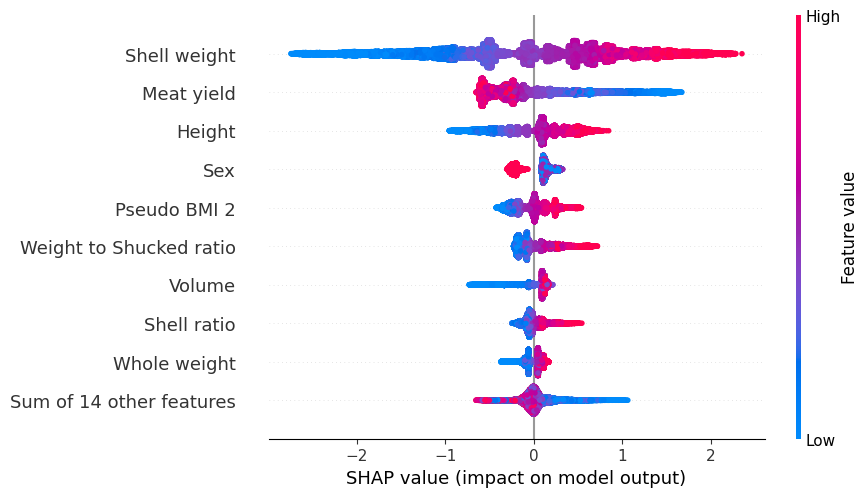

In [ ]:
# visualize the beeswarm plot
shap.plots.beeswarm(shap_values)

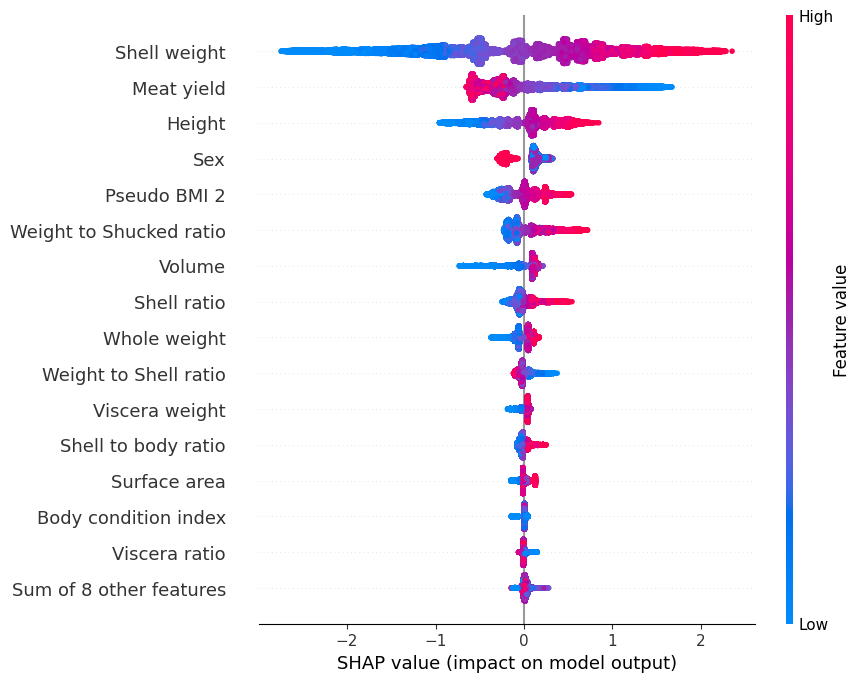

In [ ]:
shap.plots.beeswarm(shap_values, max_display=16)

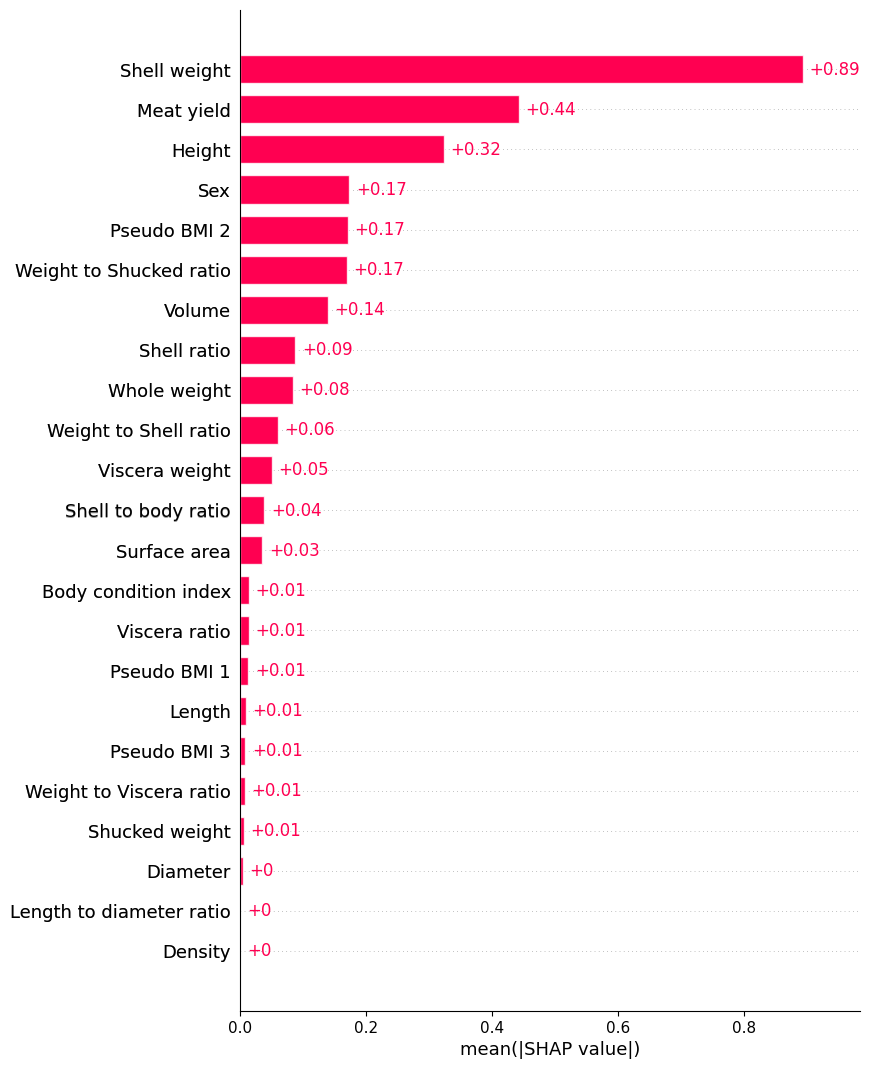

In [ ]:
shap.plots.bar(shap_values, max_display=24)

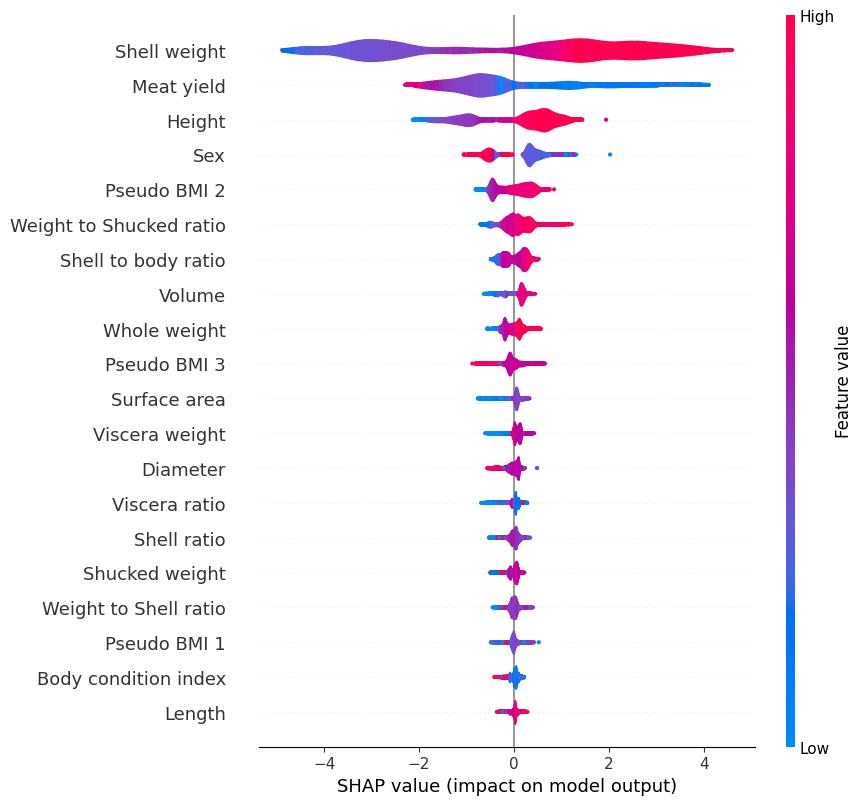

In [ ]:
shap.plots.violin(shap_values, )

In [ ]:
# shap.plots.partial_dependence(cbc, X_train, shap_values)

In [ ]:
# shap.dependence_plot("rank(1)", shap_values, X_train, interaction_index="Length")

## Save the data

In [ ]:
description = "Logging Data for vote result"
with mlflow.start_run(description= description):
    mlflow.log_artifact('output')

In [ ]:
description = "Logging Data for complex result"
with mlflow.start_run(description= description):
    mlflow.log_artifact('output')

In [ ]:
from dagshub import get_repo_bucket_client
# Get a boto3.client object
s3 = get_repo_bucket_client("SantanuK/Kaggle-Competitions-Lab")

# Upload file
s3.upload_file(
    Bucket="Kaggle-Competitions-Lab",  # name of the repo
    Filename="train.csv",  # local path of file to upload
    Key="remote.csv",  # remote path where to upload the file
)
# Download file
s3.download_file(
    Bucket="Kaggle-Competitions-Lab",  # name of the repo
    Key="remote.csv",  #  remote path from where to download the file
    Filename="local.csv",  # local path where to download the file
)